In [8]:
import os
import numpy as np
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from learned_tuning.learned_tuning import calculate_learned_tuning_PBE_subsets, calculate_place_field_fidelity_of_learned_tuning
from sklearn.linear_model import LinearRegression
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import LogLocator
from scipy.stats import stats
from scipy.stats import norm, wilcoxon, linregress

%matplotlib widget

def gausswindow(sigma, halfwidth):
    """
    Compute a Gaussian window function.

    Parameters
    ----------
    sigma : float
        Standard deviation of the Gaussian distribution.
    halfwidth : int
        Half the length of the window.

    Returns
    -------
    win : numpy.ndarray
        The Gaussian window function.

    """
    mu = 0
    x = np.arange(mu - halfwidth, mu + halfwidth + 1)
    y = np.zeros(x.shape)
    
    for i in range(len(x)):
        y[i] = (1/(sigma*np.sqrt(2*np.pi))) * np.exp(-(x[i] - mu)**2 / (2*sigma**2))
    
    win = y/np.sum(y)
    
    return win


z_score = lambda x:(x-np.nanmean(x)) /np.std(x) # the function to calculate z-score
# p_score = lambda x:[100 * np.sum(value > x) / len(x) for value in x] # this should work too, but the following version might be easier to interpret ...
def p_score(arr):
    percentile_scores = []
    n = len(arr)
    for i in range(n):
        current_element = arr[i]
        count = np.sum(current_element > arr)  # Count elements greater than current_element
        percentile = (count / n) * 100  # Calculate the percentile score
        percentile_scores.append(percentile)

    return percentile_scores

normalize_to_max = lambda x:(x/max(x))

num_shuffles = 10000

main_dir = '/home/kouroshmaboudi/Documents/Learned_tuning_Python/Datasets/'
rr = os.listdir(main_dir)


session_name_mapping = {'Achilles_10252013': 'Rat A linear',
                        'Achilles_11012013': 'Rat A circular',
                        'Buddy_06272013': 'Rat B',
                        'Cicero_09172014': 'Rat C',
                        'Gatsby_08282013':'Rat G',
                        'RatN_Day2_2019-10-11_03-58-54': 'Rat N',
                        'RatS-Day2-2020-11-27_10-22-29': 'Rat S',
                        'RatU_Day2NSD_2021-07-24_08-16-38': 'Rat U',
                        'RatV_Day1NSD_2021-10-02_08-10-23': 'Rat V linear',
                        'RatV_Day3NSD_2021-10-07_08-10-12': 'Rat V semicircular',
                        'Roy-maze1': 'Rat R',
                        'Ted-maze1': 'Rat T linear',
                        'Ted-maze2': 'Rat T L shape',
                        'Ted-maze3': 'Rat T U shape',
                        'Kevin-maze1': 'Rat K'}

current_sessions = [8, 9, 10] # 

number_of_sessions = len(current_sessions)


epoch_names = ['pre', 'maze', 'post', 'post_nrem', 'post_qw', 'post_late', 'maze_theta', 'remaze_theta'] # combination of behavioral epoch and sleep/wake state



#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Define variables

# Units firing features
stable_unit_index = np.empty((number_of_sessions,), dtype=object)
above_1Hz_PF_unit_index = np.empty((number_of_sessions,), dtype=object)
stable_above_1Hz_PF_unit_index = np.empty((number_of_sessions,), dtype=object)
stable_below_1Hz_PF_unit_index = np.empty((number_of_sessions,), dtype=object)

each_unit_session_number = np.empty((number_of_sessions,), dtype=object) # to keep track of session identity for each unit when we pool together and sort the units from diferent sessions
each_unit_within_session_unit_index = np.empty((number_of_sessions,), dtype=object) # later we need to acess units with indexes from specific sessions

num_stable_units = np.empty((number_of_sessions,), dtype=int)


# Learned tunings
learned_tunings = np.empty((number_of_sessions,), dtype=object)
learned_tunings_before_normalization = np.empty((number_of_sessions,), dtype=object)

post_learned_tunings_stability = np.empty((number_of_sessions,), dtype=object)


# MAZE_related variables
spatial_tunings_maze = np.empty((number_of_sessions,), dtype=object) # spatial tunings on MAZE
spatial_tunings_maze_before_normalization = np.empty((number_of_sessions,), dtype=object)
spatial_info_maze = np.empty((number_of_sessions,), dtype=object)

place_field_stability_maze = np.empty((number_of_sessions,), dtype=object) # stability of MAZE place fields across blocks of MAZE
spatial_tuning_feature = np.empty((number_of_sessions,), dtype=object) # spatial information of neurons on MAZE

learned_tunings_place_field_corr = np.empty((number_of_sessions,), dtype=object)
learned_tunings_place_field_corr_unit_id_shuffle = np.empty((number_of_sessions,), dtype=object)
learned_tunings_maze_theta_corr = np.empty((number_of_sessions,), dtype=object)
learned_tunings_maze_theta_corr_unit_id_shuffle = np.empty((number_of_sessions,), dtype=object)


# reMAZE-related variables
spatial_tunings_remaze = np.empty((number_of_sessions,), dtype=object) # spatial tunings on reMAZE
spatial_tunings_remaze_before_normalization = np.empty((number_of_sessions,), dtype=object)
spatial_info_remaze = np.empty((number_of_sessions,), dtype=object)

learned_tunings_remaze_place_field_corr = np.empty((number_of_sessions,), dtype=object)
learned_tunings_remaze_place_field_corr_unit_id_shuffle = np.empty((number_of_sessions,), dtype=object)
learned_tunings_remaze_theta_corr = np.empty((number_of_sessions,), dtype=object)
learned_tunings_remaze_theta_corr_unit_id_shuffle = np.empty((number_of_sessions,), dtype=object)


place_field_similarity_maze_remaze = np.empty((number_of_sessions,), dtype=object)
place_field_similarity_maze_remaze_unit_id_shuffle = np.empty((number_of_sessions,), dtype=object)


#-----------------------------------------------------------------------------------------------------
# Loading the NREM and QW learned tunings
# The LTs were recalculated for modified brain state detection

filename = f'learned_tunings_vs_posterior_gini_coeffs_NREM_QW.npy'
file_path = os.path.join('/home/kouroshmaboudi/Documents/Learned_tuning_Python', filename)

load_data = np.load(file_path, allow_pickle=True).item()
NREM_QW_learned_tunings = load_data['learned_tunings']

#-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Loop over sessions

gw = gausswindow(3, 9) # for smoothing the tunings 

for session_idx in range(number_of_sessions):
    session_number = current_sessions[session_idx]
    session_name = rr[session_number]

    print(session_name)

    session_dataset_path = os.path.join(main_dir, session_name)


    #----------------------------------------------------------------------------------------------------------------------------------------------------------------------
    # Load epochs information
    

    filename = f'{session_name}.fileInfo_for_python.mat'
    file_path = os.path.join(session_dataset_path, filename)

    mat_file = loadmat(file_path)
    session_info = mat_file["fileInfo"]

    epochs = session_info["behavior"][0][0][0][0]["time"]
    epoch_durations = epochs[:, 1] - epochs[:, 0]


    #------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    # Spatial tunings during MAZE and reMAZE
  
    spikes_pyr = loadmat(os.path.join(session_dataset_path, session_name + '.spikes_for_python.mat'))['spikes_pyr']
    
    num_units_total = spikes_pyr["spatialTuning_smoothed"][0].shape[0]
    if num_units_total <= 1:
        num_units_total = spikes_pyr["spatialTuning_smoothed"].shape[0]

    each_unit_session_number[session_idx] = np.full((num_units_total,), session_number)
    each_unit_within_session_unit_index[session_idx] = np.arange(num_units_total)

    num_pos_bins = spikes_pyr["spatialTuning_smoothed"][0][0]['uni'][0][0].size
    


    #-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    # Load unit stability by recording block data (PRE, POST, latePOST)
    
    filename = f'{session_name}.cluster_quality_by_block'
    file_path = os.path.join(session_dataset_path, filename)

    mat_file = loadmat(file_path)
    cluster_quality_by_block = mat_file['cluster_quality_by_block'][0]


    #---------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    # Load and process Spike data

    spikes = [] # spike data and place field info of each unit

    # attributes = list(spikes_pyr.dtype.names) % if we want to work on all variable in the imported .mat data structure
    running_directions = {'uni'}
    other_attributes   = {'spike_times', 'shank_id','cluster_id'}

    iter = 0
    for unit in range(num_units_total):
        
        # Create dictionaries for each unit and store the matrices
        unit_spikes = dict()
        
        unit_spikes['place_fields_maze']  = {}
        unit_spikes['spatial_info_maze'] = {}
        
        if session_number in range(8, 11):
            unit_spikes['place_fields_remaze']  = {}
            unit_spikes['spatial_info_remaze'] = {}

        for direction in running_directions:
            try:
                if session_number in [6, 7]:  # including RatS  
                    unit_spikes['place_fields_maze'][direction] = spikes_pyr["spatialTuning_smoothed"][unit][0][direction][0][0].reshape(num_pos_bins) 
                    unit_spikes['spatial_info_maze'][direction] = spikes_pyr['spatialInfo'][unit][0][direction][0][0][0][0]
                else:
                    unit_spikes['place_fields_maze'][direction] = spikes_pyr["spatialTuning_smoothed"][0][unit][direction][0][0].reshape(num_pos_bins) 
                    unit_spikes['spatial_info_maze'][direction] = spikes_pyr['spatialInfo'][0][unit][direction][0][0][0][0]
                
                if session_number in range(8, 11):
                    unit_spikes['place_fields_remaze'][direction] = spikes_pyr["spatialTuning_smoothed_re"][0][unit][direction][0][0].reshape(num_pos_bins) 
                    unit_spikes['spatial_info_remaze'][direction] = spikes_pyr['spatialInfo_re'][0][unit][direction][0][0][0][0]
                    
            except ValueError:
                if iter == 0:
                    print("This session has only one running direction")
                iter += 1

       
        if session_number in [9, 10]: # for Rat V sessions
            unit_spikes['spike_times'] = spikes_pyr['time'][0][unit]
            unit_spikes['shank_id']    = spikes_pyr['id'][0][unit][0][1] 
            unit_spikes['cluster_id']  = spikes_pyr['id'][0][unit][0][0]

        elif session_number in [6, 7]: # for RatN and RatS
            unit_spikes['spike_times'] = spikes_pyr['time'][unit][0] 
            unit_spikes['shank_id']    = spikes_pyr['id'][unit][0][0][0]-1
            unit_spikes['cluster_id']  = spikes_pyr['id'][unit][0][0][1]

        elif session_number == 8: # RatU  
            unit_spikes['spike_times'] = spikes_pyr['time'][0][unit]
            unit_spikes['shank_id']    = spikes_pyr['id'][0][unit][0][0] # shank indices already starts at zero
            unit_spikes['cluster_id']  = spikes_pyr['id'][0][unit][0][1]

        else:
            unit_spikes['spike_times'] = spikes_pyr['time'][0][unit]
            unit_spikes['shank_id']    = spikes_pyr['id'][0][unit][0][0]-1 # need to go one down for the other datasets
            unit_spikes['cluster_id']  = spikes_pyr['id'][0][unit][0][1]



        #------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
        # Extract the cluster quality information by block for the current unit

        curr_unit_idx = np.where(cluster_quality_by_block['cluster_ids'][unit_spikes['shank_id']] == unit_spikes['cluster_id'])[0]
        
        spike_amplitude_by_block = cluster_quality_by_block['spike_amplitude_by_block'][unit_spikes['shank_id']][curr_unit_idx]
        spike_amplitude_by_block = np.nan_to_num(spike_amplitude_by_block, nan=0)
        spike_amplitude_by_block_percent = spike_amplitude_by_block/cluster_quality_by_block['session_mean_spike_amplitude'][unit_spikes['shank_id']][curr_unit_idx]# as a percentage of session mean
        unit_spikes['spike_amplitude_by_block'] = spike_amplitude_by_block_percent

        firing_rate_by_block = cluster_quality_by_block['firing_rate_by_block'][unit_spikes['shank_id']][curr_unit_idx]
        firing_rate_by_block = np.nan_to_num(firing_rate_by_block, nan=0)
        # firing_rate_by_block_percent = firing_rate_by_block/cluster_quality_by_block['session_mean_firing_rate'][unit_spikes['shank_id']][curr_unit_idx]
        if firing_rate_by_block.shape[1] == 2: 
            sleep_firing_rate = (firing_rate_by_block[0][0]*epoch_durations[0] + firing_rate_by_block[0][1]*epoch_durations[2])/np.sum(epoch_durations[[0,2]])
        elif firing_rate_by_block.shape[1] == 3:
            sleep_firing_rate = (firing_rate_by_block[0][0]*epoch_durations[0] + firing_rate_by_block[0][1]*4*3600 + firing_rate_by_block[0][2]*(epoch_durations[2]-4*3600))/np.sum(epoch_durations[[0,2]])

        if sleep_firing_rate > 0:
            firing_rate_by_block_percent = firing_rate_by_block/sleep_firing_rate
        else:
            firing_rate_by_block_percent = np.zeros((len(firing_rate_by_block),))

        unit_spikes['firing_rate_by_block'] = firing_rate_by_block_percent                

        isolation_distance_by_block = cluster_quality_by_block['isolation_distance_by_block'][unit_spikes['shank_id']][curr_unit_idx]
        isolation_distance_by_block = np.nan_to_num(isolation_distance_by_block, nan=0)
        unit_spikes['isolation_distance_by_block'] = isolation_distance_by_block



        unit_spikes['pre_post_unit_stability'] = (
            # (unit_spikes['spike_amplitude_by_block'][0] > 0.8) & 
            (unit_spikes['firing_rate_by_block'][0] > 0.33) & 
            (unit_spikes['isolation_distance_by_block'][0] > 15)
        ).all()

        spikes.append(unit_spikes) 



    # -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    # Process MAZE and reMAZE spatial tunings
    
    interp_pos_bins = np.linspace(0, num_pos_bins, 200)
    num_pos_bins_interp = len(interp_pos_bins)


    spatial_tunings_maze_before_normalization[session_idx] = np.zeros((num_units_total, num_pos_bins_interp))
    spatial_tunings_maze[session_idx] = np.zeros((num_units_total, num_pos_bins_interp))
    spatial_info_maze[session_idx] = np.full((num_units_total,), np.nan)

    pre_post_unit_stability_curr_session = np.empty((num_units_total,))

    for unit in range(num_units_total):

        spatial_tuning_maze_curr_unit = spikes[unit]['place_fields_maze']['uni']
        spatial_tuning_maze_curr_unit = np.interp(interp_pos_bins, np.arange(1, num_pos_bins+1), spatial_tuning_maze_curr_unit)

        """
        Normalize the spatial tunings; zscoring (for multiple regression analysis), or set the max amplitude to one (for plotting the heatmaps)
        """
        spatial_tunings_maze_before_normalization[session_idx][unit] = spatial_tuning_maze_curr_unit
        spatial_tunings_maze[session_idx][unit] = z_score(spatial_tuning_maze_curr_unit)

        spatial_info_maze[session_idx][unit] = spikes[unit]['spatial_info_maze']['uni']
        pre_post_unit_stability_curr_session[unit] = spikes[unit]['pre_post_unit_stability']


    stable_unit_index[session_idx] = pre_post_unit_stability_curr_session == True
    above_1Hz_PF_unit_index[session_idx] = np.nanmax(spatial_tunings_maze_before_normalization[session_idx], axis=1) > 1
    
    stable_above_1Hz_PF_unit_index[session_idx]  = np.logical_and(stable_unit_index[session_idx], above_1Hz_PF_unit_index[session_idx])
    stable_below_1Hz_PF_unit_index[session_idx]  = np.logical_and(stable_unit_index[session_idx], ~above_1Hz_PF_unit_index[session_idx])


    num_stable_units[session_idx] = len(stable_above_1Hz_PF_unit_index[session_idx])



    #---------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    # reMAZE spatial tunings (all session except RatS with animal's positon on reMAZE recorded)

    spatial_tunings_remaze_before_normalization[session_idx] = np.zeros((num_units_total, num_pos_bins_interp))
    spatial_tunings_remaze[session_idx] = np.zeros((num_units_total, num_pos_bins_interp))
    spatial_info_remaze[session_idx] = np.full((num_units_total,), np.nan)

    for unit in range(num_units_total):
        
        if session_number in range(8, 11):  # RatU_Day2, RatV_Day1, RatV_day3
            
            spatial_tuning_remaze_curr_unit = spikes[unit]['place_fields_remaze']['uni']
            spatial_tuning_remaze_curr_unit = np.interp(interp_pos_bins, np.arange(1, num_pos_bins+1), spatial_tuning_remaze_curr_unit)

            spatial_tunings_remaze_before_normalization[session_idx][unit] = spatial_tuning_remaze_curr_unit
            spatial_tunings_remaze[session_idx][unit] = z_score(spatial_tuning_remaze_curr_unit) 

            spatial_info_remaze[session_idx][unit] = spikes[unit]['spatial_info_remaze']['uni']


    #--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    # MAZE and reMAZE place field similarity

    place_field_similarity_maze_remaze[session_idx] = dict()
    place_field_similarity_maze_remaze_unit_id_shuffle[session_idx] = dict()

    for epoch, epoch_name in enumerate(epoch_names):        
        (place_field_similarity_maze_remaze[session_idx],
        place_field_similarity_maze_remaze_unit_id_shuffle[session_idx],
        _) = calculate_place_field_fidelity_of_learned_tuning(
                spatial_tunings_remaze[session_idx],
                spatial_tunings_maze[session_idx],
                num_shuffles
            )

    
    #-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    # load MAZE PF stability
    # I calculated the percentile score for each (across-blocks) stable unit with peak firing rate above 1Hz
    # For units with peak firing rate below 1 Hz or units with unstable firing the place field stability is not defined

    maze_place_field_stabilities_curr_session = loadmat(os.path.join(session_dataset_path, session_name + '.PFstability.mat'))['PF_stability_across_blocks']

    place_field_stability_maze[session_idx] = np.full((num_units_total,), np.nan)
    place_field_stability_maze[session_idx][stable_above_1Hz_PF_unit_index[session_idx]] = p_score(maze_place_field_stabilities_curr_session[stable_above_1Hz_PF_unit_index[session_idx]]) 



    #--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    # Load the learned tunings for each epoch

    learned_tunings_curr_session = dict()


    # Import results from Matlab and reformat
    mat_file = loadmat(os.path.join(session_dataset_path, session_name + '.assemblyTunings_allPBEs_Lthresh1e_3.mat'))
    for epoch in [0, 2]: # PRE and POST
        curr_epoch = epoch_names[epoch]
        learned_tunings_curr_session[curr_epoch] = mat_file["assemblyTunings"][curr_epoch].item()['data'].item()
    
    learned_tunings_curr_session['maze'] = mat_file["assemblyTunings"]['run'].item()['data'].item()


    # # If we instead use learned tunings limited to NREM or QW periods

    if session_name == 'RatU_Day2NSD_2021-07-24_08-16-38':
        current_session_idx = 7 # the last session index corresponds to Kevin. Check the posterior Gini coeff code, where the NREM and QW LTs (not matching time bins across epochs) were calcualted
    elif session_name == 'RatV_Day1NSD_2021-10-02_08-10-23':
        current_session_idx = 8
    elif session_name == 'RatV_Day3NSD_2021-10-07_08-10-12':
        current_session_idx = 9

    for epoch in ['pre', 'post']:
        for ripple_category in ['nrem', 'qw']:
            learned_tunings_curr_session[f'{epoch}_{ripple_category}'] = NREM_QW_learned_tunings[current_session_idx][epoch][ripple_category.upper()]



    # filename = f'{session_name}.learned_tunings_NREM_vs_QW.npy'
    # file_path = os.path.join(session_dataset_path, filename)
    # learned_tunings_NREM_vs_QW = np.load(file_path, allow_pickle = True).item()

    # # learned_tunings_curr_session['pre'] = learned_tunings_NREM_vs_QW['PRE']['learned_tunings_NREM']
    # # learned_tunings_curr_session['post'] = learned_tunings_NREM_vs_QW['POST']['learned_tunings_NREM']
    # learned_tunings_curr_session['post_nrem'] = learned_tunings_NREM_vs_QW['POST']['learned_tunings_NREM']
    # learned_tunings_curr_session['post_qw'] = learned_tunings_NREM_vs_QW['POST']['learned_tunings_QW']
    



    # late POST
    mat_file = loadmat(os.path.join(session_dataset_path, session_name + '.assemblyTunings_allPBEs_last4hoursPOST.mat'))
    learned_tunings_curr_session['post_late'] = mat_file["assemblyTunings"]['post'].item()['data'].item()



    # MAZE theta learned tunings
    mat_file = loadmat(os.path.join(session_dataset_path, session_name + '.assemblyTunings_activeRun_binDur0.02.mat'))
    learned_tunings_curr_session['maze_theta'] = mat_file['learnedTunings']


    #REMAZE theta learned tunings
    mat_file = loadmat(os.path.join(session_dataset_path, session_name + '.assemblyTunings_remaze_stricterThetaDetection.mat'))
    learned_tunings_curr_session['remaze_theta'] = mat_file['learnedTunings']



    #----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    # Reformat the learned tunings

    learned_tunings[session_idx] = dict()
    learned_tunings_before_normalization[session_idx] = dict()

    
    num_shuffles = 10000
    for epoch, epoch_name in enumerate(epoch_names):

        learned_tunings[session_idx][epoch_name] = np.full((num_units_total, num_pos_bins_interp), np.nan)
        learned_tunings_before_normalization[session_idx][epoch_name] = np.full((num_units_total, num_pos_bins_interp), np.nan)

        for unit in range(num_units_total):
            curr_unit_learned_tuning = learned_tunings_curr_session[epoch_name][unit]

            if len(curr_unit_learned_tuning) != num_pos_bins_interp:
                curr_unit_learned_tuning = curr_unit_learned_tuning.reshape(num_pos_bins)
                curr_unit_learned_tuning = np.interp(interp_pos_bins, np.arange(1, num_pos_bins+1), curr_unit_learned_tuning)
            else:
                curr_unit_learned_tuning = curr_unit_learned_tuning.reshape(num_pos_bins_interp)
                
            curr_unit_learned_tuning[np.isnan(curr_unit_learned_tuning)] = 0

            # An additional smoothing of the learned tunings during the sleep epochs
            if epoch in range(1,5): # PRE, MAZE, POST, or latePOST
                curr_unit_learned_tuning = np.convolve(curr_unit_learned_tuning, gw, mode='same')

            # Normalize
            learned_tunings[session_idx][epoch_name][unit] = z_score(curr_unit_learned_tuning)
            learned_tunings_before_normalization[session_idx][epoch_name][unit] = curr_unit_learned_tuning

    #------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    # MAZE place field fidelities of the learned tunings

    learned_tunings_place_field_corr[session_idx] = dict()
    learned_tunings_place_field_corr_unit_id_shuffle[session_idx] = dict()

    for epoch, epoch_name in enumerate(epoch_names):        
        (learned_tunings_place_field_corr[session_idx][epoch_name],
        learned_tunings_place_field_corr_unit_id_shuffle[session_idx][epoch_name],
        _) = calculate_place_field_fidelity_of_learned_tuning(
                learned_tunings[session_idx][epoch_name],
                spatial_tunings_maze[session_idx],
                num_shuffles
            )
        

    #-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    # reMAZE place field fidelities of the learned tunings
    learned_tunings_remaze_place_field_corr[session_idx] = dict()
    learned_tunings_remaze_place_field_corr_unit_id_shuffle[session_idx] = dict()
    
    for epoch, epoch_name in enumerate(epoch_names):        
        (learned_tunings_remaze_place_field_corr[session_idx][epoch_name],
        learned_tunings_remaze_place_field_corr_unit_id_shuffle[session_idx][epoch_name],
        _) = calculate_place_field_fidelity_of_learned_tuning(
                learned_tunings[session_idx][epoch_name],
                spatial_tunings_remaze[session_idx],
                num_shuffles
            )
        
    #------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    # MAZE theta LT similarity of the learned tunings

    learned_tunings_maze_theta_corr[session_idx] = dict()
    learned_tunings_maze_theta_corr_unit_id_shuffle[session_idx] = dict()
    
    current_epochs = [epoch for epoch in epoch_names if epoch not in ['maze_theta', 'remaze_theta']]

    for epoch, epoch_name in enumerate(current_epochs):        
        (learned_tunings_maze_theta_corr[session_idx][epoch_name],
        learned_tunings_maze_theta_corr_unit_id_shuffle[session_idx][epoch_name],
        _) = calculate_place_field_fidelity_of_learned_tuning(
                learned_tunings[session_idx][epoch_name],
                learned_tunings[session_idx]['maze_theta'],
                num_shuffles
            )


    #-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    # reMAZE theta LT similarity of the learned tunings

    learned_tunings_remaze_theta_corr[session_idx] = dict()
    learned_tunings_remaze_theta_corr_unit_id_shuffle[session_idx] = dict()
    
    current_epochs = [epoch for epoch in epoch_names if epoch not in ['remaze_theta']]

    for epoch, epoch_name in enumerate(current_epochs):        
        (learned_tunings_remaze_theta_corr[session_idx][epoch_name],
        learned_tunings_remaze_theta_corr_unit_id_shuffle[session_idx][epoch_name],
        _) = calculate_place_field_fidelity_of_learned_tuning(
                learned_tunings[session_idx][epoch_name],
                learned_tunings[session_idx]['remaze_theta'],
                num_shuffles
            )

    # POST learned tuning stability
    mat_file = loadmat(os.path.join(session_dataset_path, session_name + '.POSTstability.mat'))
    post_learned_tunings_stability[session_idx] = np.concatenate(mat_file['POSTstabilities'])


RatU_Day2NSD_2021-07-24_08-16-38


/tmp/ipykernel_106559/470445953.py:46: RuntimeWarning: invalid value encountered in divide
  z_score = lambda x:(x-np.nanmean(x)) /np.std(x) # the function to calculate z-score


RatV_Day1NSD_2021-10-02_08-10-23
RatV_Day3NSD_2021-10-07_08-10-12


##### Concatenate the variables over sessions

In [9]:
# Each units's trackable unit and session indexes- pooled across sessions
each_unit_session_number_session_concat = np.concatenate(each_unit_session_number, axis=0)
each_unit_within_session_unit_index_session_concat = np.concatenate(each_unit_within_session_unit_index, axis=0)

# Units firing features
above_1Hz_PF_unit_index_session_concat = np.concatenate(above_1Hz_PF_unit_index, axis=0)
stable_above_1Hz_PF_unit_index_session_concat = np.concatenate(stable_above_1Hz_PF_unit_index, axis=0)
stable_below_1Hz_PF_unit_index_session_concat = np.concatenate(stable_below_1Hz_PF_unit_index, axis=0)


#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# MAZE and reMAZE place fields
spatial_tunings_maze_sessions_concat = np.concatenate(spatial_tunings_maze, axis=0)
spatial_tunings_remaze_sessions_concat = np.concatenate(spatial_tunings_remaze, axis=0)


#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# MAZE and reMAZE place field similarity

place_field_similarity_maze_remaze_sessions_concat = dict.fromkeys(epoch_names)
place_field_similarity_maze_remaze_unit_id_shuffle_concat = dict.fromkeys(epoch_names)
place_field_similarity_maze_remaze_median_pooled = dict.fromkeys(epoch_names)
place_field_similarity_maze_remaze_pvalue_pooled = dict.fromkeys(epoch_names)

# Data
place_field_similarity_maze_remaze_sessions_concat = np.concatenate(place_field_similarity_maze_remaze, axis = 0)

# Shuffle
place_field_similarity_maze_remaze_unit_id_shuffle_concat = np.concatenate(place_field_similarity_maze_remaze_unit_id_shuffle, axis = 0)

# Stats
place_field_similarity_maze_remaze_median_pooled = np.nanmedian(place_field_similarity_maze_remaze_sessions_concat)  
ui_pf_pf_correlation_medians = np.nanmedian(place_field_similarity_maze_remaze_unit_id_shuffle_concat, axis = 0)

place_field_similarity_maze_remaze_pvalue_pooled = np.sum(ui_pf_pf_correlation_medians >= place_field_similarity_maze_remaze_median_pooled)/num_shuffles


#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Learned tunings
learned_tunings_sessions_concat = dict.fromkeys(epoch_names)
for epoch, epoch_name in enumerate(epoch_names):
    temp = []
    for session_idx in range(number_of_sessions):
        temp.append(learned_tunings[session_idx][epoch_name])
    learned_tunings_sessions_concat[epoch_name] = np.concatenate(temp, axis = 0)


# POST learned tunings stabilities
temp = []
for session_idx in range(number_of_sessions):
    temp.append(post_learned_tunings_stability[session_idx])
post_learned_tunings_stability_session_concat = np.concatenate(temp, axis=0)



#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# MAZE place field fidelities of the learned tunings
learned_tunings_place_field_corr_sessions_concat = dict.fromkeys(epoch_names)
learned_tunings_place_field_corr_unit_id_shuffle_concat = dict.fromkeys(epoch_names)
learned_tunings_place_field_corr_median_pooled = dict.fromkeys(epoch_names)
learned_tunings_place_field_corr_pvalue_pooled = dict.fromkeys(epoch_names)

for epoch, epoch_name in enumerate(epoch_names):
    
    # Data
    temp = []
    for session_idx in range(number_of_sessions):
        temp.append(learned_tunings_place_field_corr[session_idx][epoch_name])
    learned_tunings_place_field_corr_sessions_concat[epoch_name] = np.concatenate(temp, axis = 0)

    # Shuffle
    temp = []
    for session_idx in range(number_of_sessions):
        temp.append(learned_tunings_place_field_corr_unit_id_shuffle[session_idx][epoch_name])
    learned_tunings_place_field_corr_unit_id_shuffle_concat[epoch_name] = np.concatenate(temp, axis = 0)
    
    # Stats
    learned_tunings_place_field_corr_median_pooled[epoch_name] = np.nanmedian(learned_tunings_place_field_corr_sessions_concat[epoch_name])  
    ui_lt_pf_correlation_medians = np.nanmedian(learned_tunings_place_field_corr_unit_id_shuffle_concat[epoch_name], axis = 0)

    learned_tunings_place_field_corr_pvalue_pooled[epoch_name] = np.sum(ui_lt_pf_correlation_medians >= learned_tunings_place_field_corr_median_pooled[epoch_name])/num_shuffles


#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# reMAZE place field fidelities of the learned tunings
learned_tunings_remaze_place_field_corr_sessions_concat = dict.fromkeys(epoch_names)
learned_tunings_remaze_place_field_corr_unit_id_shuffle_concat = dict.fromkeys(epoch_names)
learned_tunings_remaze_place_field_corr_median_pooled = dict.fromkeys(epoch_names)
learned_tunings_remaze_place_field_corr_pvalue_pooled = dict.fromkeys(epoch_names)

for epoch, epoch_name in enumerate(epoch_names):
    
    # Data
    temp = []
    for session_idx in range(number_of_sessions):
        temp.append(learned_tunings_remaze_place_field_corr[session_idx][epoch_name])
    learned_tunings_remaze_place_field_corr_sessions_concat[epoch_name] = np.concatenate(temp, axis = 0)

    # Shuffle
    temp = []
    for session_idx in range(number_of_sessions):
        temp.append(learned_tunings_remaze_place_field_corr_unit_id_shuffle[session_idx][epoch_name])
    learned_tunings_remaze_place_field_corr_unit_id_shuffle_concat[epoch_name] = np.concatenate(temp, axis = 0)
    
    # Stats
    learned_tunings_remaze_place_field_corr_median_pooled[epoch_name] = np.nanmedian(learned_tunings_remaze_place_field_corr_sessions_concat[epoch_name])  
    ui_lt_pf_correlation_medians = np.nanmedian(learned_tunings_remaze_place_field_corr_unit_id_shuffle_concat[epoch_name], axis = 0)

    learned_tunings_remaze_place_field_corr_pvalue_pooled[epoch_name] = np.sum(ui_lt_pf_correlation_medians >= learned_tunings_remaze_place_field_corr_median_pooled[epoch_name])/num_shuffles



#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# MAZE theta learned tunings fidelities of the learned tunings

learned_tunings_maze_theta_corr_sessions_concat = dict.fromkeys(epoch_names)
learned_tunings_maze_theta_corr_unit_id_shuffle_concat = dict.fromkeys(epoch_names)
learned_tunings_maze_theta_corr_median_pooled = dict.fromkeys(epoch_names)
learned_tunings_maze_theta_corr_pvalue_pooled = dict.fromkeys(epoch_names)

current_epochs = [epoch for epoch in epoch_names if epoch not in ['maze_theta','remaze_theta']]

for epoch, epoch_name in enumerate(current_epochs):
    
    # Data
    temp = []
    for session_idx in range(number_of_sessions):
        temp.append(learned_tunings_maze_theta_corr[session_idx][epoch_name])
    learned_tunings_maze_theta_corr_sessions_concat[epoch_name] = np.concatenate(temp, axis = 0)

    # Shuffle
    temp = []
    for session_idx in range(number_of_sessions):
        temp.append(learned_tunings_maze_theta_corr_unit_id_shuffle[session_idx][epoch_name])
    learned_tunings_maze_theta_corr_unit_id_shuffle_concat[epoch_name] = np.concatenate(temp, axis = 0)
    
    # Stats
    learned_tunings_maze_theta_corr_median_pooled[epoch_name] = np.nanmedian(learned_tunings_maze_theta_corr_sessions_concat[epoch_name])  
    ui_lt_lt_correlation_medians = np.nanmedian(learned_tunings_maze_theta_corr_unit_id_shuffle_concat[epoch_name], axis = 0)

    learned_tunings_maze_theta_corr_pvalue_pooled[epoch_name] = np.sum(ui_lt_lt_correlation_medians >= learned_tunings_maze_theta_corr_median_pooled[epoch_name])/num_shuffles


#------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# reMAZE theta learned tunings fidelities of the learned tunings

learned_tunings_remaze_theta_corr_sessions_concat = dict.fromkeys(epoch_names)
learned_tunings_remaze_theta_corr_unit_id_shuffle_concat = dict.fromkeys(epoch_names)
learned_tunings_remaze_theta_corr_median_pooled = dict.fromkeys(epoch_names)
learned_tunings_remaze_theta_corr_pvalue_pooled = dict.fromkeys(epoch_names)

current_epochs = [epoch for epoch in epoch_names if epoch not in ['remaze_theta']]

for epoch, epoch_name in enumerate(current_epochs):
    
    # Data
    temp = []
    for session_idx in range(number_of_sessions):
        temp.append(learned_tunings_remaze_theta_corr[session_idx][epoch_name])
    learned_tunings_remaze_theta_corr_sessions_concat[epoch_name] = np.concatenate(temp, axis = 0)

    # Shuffle
    temp = []
    for session_idx in range(number_of_sessions):
        temp.append(learned_tunings_remaze_theta_corr_unit_id_shuffle[session_idx][epoch_name])
    learned_tunings_remaze_theta_corr_unit_id_shuffle_concat[epoch_name] = np.concatenate(temp, axis = 0)
    
    # Stats
    learned_tunings_remaze_theta_corr_median_pooled[epoch_name] = np.nanmedian(learned_tunings_remaze_theta_corr_sessions_concat[epoch_name])  
    ui_lt_lt_correlation_medians = np.nanmedian(learned_tunings_remaze_theta_corr_unit_id_shuffle_concat[epoch_name], axis = 0)

    learned_tunings_remaze_theta_corr_pvalue_pooled[epoch_name] = np.sum(ui_lt_lt_correlation_medians >= learned_tunings_remaze_theta_corr_median_pooled[epoch_name])/num_shuffles



In [10]:
place_field_stability_maze_concat = np.concatenate(place_field_stability_maze, axis=0)

### figure 5f - MAZE/reMAZE similarity vs POST fidelity
Also, MAZE/reMAZE theta LT similarity vs POST LT similarity with MAZE theta LT

In [37]:

#------------------------------------------------------------------------------------------------------------------------------------------------
# Regression
 
y = place_field_similarity_maze_remaze_sessions_concat
x = learned_tunings_place_field_corr_sessions_concat['post_qw']

# Remove NaN values
valid_index = ~np.isnan(x) & ~np.isnan(y)

unit_subset = valid_index & stable_above_1Hz_PF_unit_index_session_concat 


x_valid = x[unit_subset]
y_valid = y[unit_subset]

# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(x_valid, y_valid)
line = slope * x_valid + intercept

/tmp/ipykernel_106559/216786266.py:17: DeprecationWarning: Please use `linregress` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  slope, intercept, r_value, p_value, std_err = stats.linregress(x_valid, y_valid)


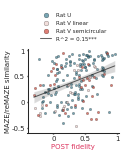

In [38]:

#--------------------------------------------------------------------------------------------------------------------------------------------------
# Scatter plot


# ---------------------------------------------------------------------------------------------------------------------------------------------------------------
# Define functions

def get_pval_statement(pvalue):
    
    if pvalue <= 0.0001:
        pvalue_statement = '***'
    elif pvalue < 0.001:
        pvalue_statement = '**'
    elif pvalue < 0.01:
        pvalue_statement = '*'
    else:
        pvalue_statement = f'P={pvalue:.2f}'
    
    return pvalue_statement

def format_ticks(x, _):
    if x == int(x):
        return str(int(x))
    else:
        return str(x)

#-----------------------------------------------------------------------------------------------------------------------------------------------------------------
# Set up figure colors and style


sns.set_style('whitegrid') 
sns.set_context('paper')

custom_params = {
    "axes.spines.top": False,
    "axes.spines.right": False
    }

sns.set_theme(style="ticks", rc=custom_params)

plt.rcParams.update({
    'font.size':6,
    'axes.linewidth':0.75,
    'pdf.fonttype':42,
    'ps.fonttype':42,
    'axes.labelsize':6,
    'axes.titlesize':8,
    'xtick.labelsize':5,
    'ytick.labelsize':5,
    'legend.fontsize':6,
    'legend.title_fontsize':6,
    'legend.frameon': False,
    'legend.markerscale':2,
    'xtick.major.size':2,
    'ytick.major.size':2
})

cmap = sns.diverging_palette(220, 15)
session_specific_colors = [cmap[i] for i in [0, 3, 5]]



#-------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Generate the figure

plotheight = 120
plotwidth = 90
font_size = 5

fig = plt.figure()
fig.set_size_inches([plotwidth/72, plotheight/72])
gs = GridSpec(nrows=1, ncols=1, figure=fig, hspace=0.3, wspace=0.5)

ax = fig.add_subplot(gs[0])


# Scatterplot

for session_idx, session_number in enumerate(current_sessions):
    session_name = rr[session_number]
    unit_subset_current_session = np.where(unit_subset & np.isin(each_unit_session_number_session_concat, session_number))[0] # & (place_field_stability_maze_concat < 50)
    sns.scatterplot(
        x=x[unit_subset_current_session],
        y=y[unit_subset_current_session],
        color = session_specific_colors[session_idx],
        marker='o',
        edgecolor = 'black',
        linewidth=0.2, 
        s=3, 
        alpha=0.7, 
        ax=ax, 
        label = session_name_mapping[session_name]
        )


# Add the regression line
sns.regplot(x=x[unit_subset], y=y[unit_subset], ci=95, color='black', scatter=False,
            label=f'R^2 = {r_value**2:.2f}{get_pval_statement(p_value)}',
            line_kws={"linewidth":0.75, "alpha":0.6},
            ax=ax)


ax.set_xlim([-0.4, 1.02])
ax.set_ylim([-0.6, 1.02])

ax.set_xlabel("POST fidelity", fontsize=font_size, color='#DC335D', labelpad=1)
ax.set_ylabel("MAZE/reMAZE similarity", fontsize=font_size, labelpad=0)

ax.tick_params(axis='both', which='major', length=1, pad=1, width=1)

ax.legend(fontsize=4, loc="upper center", bbox_to_anchor=(0.5, 1.5))

# Format the tick labels using the custom formatter
ax.xaxis.set_major_formatter(FuncFormatter(format_ticks))
ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))

# Adjust the plot layout
plt.subplots_adjust(left=0.22, right= 0.95, bottom=0.2, top=0.70)


filename = 'scatter_plot_maze_remaze_PF_similarity_vs_POST_fidelity_units_QW.pdf'
# filename = 'scatter_plot_maze_remaze_theta_LT_similarity_vs_POST_maze_theta_LT_similarity.pdf'
file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, dpi=300)

plt.show()


### Figure 5b-d: Distributions of MAZE/reMAZE similarity, POST fidelity, and reMAZE PF/POST LT similarity

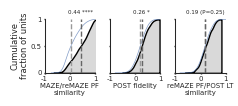

In [176]:
unit_subset = stable_above_1Hz_PF_unit_index_session_concat

curr_epoch = 'pre'


#---------------------------------------------------------------------------------------------------------
# Define functions
def format_ticks(x, _):
    if x == int(x):
        return str(int(x))
    else:
        return str(x)

def get_pval_statement(pvalue):
    if pvalue <= 0.0001:
        pvalue_statement = '****'
    elif pvalue <= 0.001:
        pvalue_statement = '***'
    elif pvalue < 0.01:
        pvalue_statement = '**'
    elif pvalue < 0.05:
        pvalue_statement = '*'
    else:
        pvalue_statement = f'(P={pvalue:.2f})'
    return pvalue_statement

#------------------------------------------------------------------------------------------------------------
# Set up colors ans styles

sns.set_style('whitegrid') # Set style and context
sns.set_context('paper')

custom_params = {"axes.spines.top": False, "axes.spines.right": False}
sns.set_theme(style="ticks", rc=custom_params)

plt.rcParams.update({
    'font.size':6,
    'axes.linewidth':0.75,
    'pdf.fonttype':42,
    'ps.fonttype':42,
    'axes.labelsize':5,
    'axes.titlesize':6,
    'xtick.labelsize':5,
    'ytick.labelsize':5,
    'legend.fontsize':5,
    'legend.title_fontsize':6,
    'legend.frameon': False,
    'legend.markerscale':2,
    'xtick.major.size':2,
    'ytick.major.size':2
})

colors = [
    '#005CE9', # PRE
    '#DD335D' # # POST
    ] 

plotheight = 55
plotwidth = 150
font_size = 5

fig = plt.figure()
fig.set_size_inches([plotwidth/72, plotheight/72])
gs = GridSpec(nrows=1, ncols=3, figure=fig, wspace=0.3, hspace=1.2)



#-------------------------------------------------------------------------------------------------------------------------
# (1) MAZE/reMAZE PF similarity

ax_1 = fig.add_subplot(gs[0])

curr_var = place_field_similarity_maze_remaze_sessions_concat[unit_subset]
curr_var_shuffle = place_field_similarity_maze_remaze_unit_id_shuffle_concat[unit_subset]

# shuffle distribution
sns.kdeplot(curr_var_shuffle.reshape(-1,1), cumulative=True, bw_method= 0.15, fill=False, color='gray', linestyle= '-', linewidth=0.5, ax= ax_1, alpha=0.7)
current_median_shuffle = np.nanmedian(curr_var_shuffle.reshape(-1,1))
ax_1.axvline(x=current_median_shuffle, color=(.6,.6,.6), linestyle = '--', linewidth=1)


# data distribution
sns.kdeplot(curr_var, cumulative=True, bw_method= 0.15, fill=True, color='black', linestyle= '-', linewidth=1, ax= ax_1, alpha=0.15)

current_median = np.nanmedian(curr_var)
current_medians_shuffle = np.nanmedian(curr_var_shuffle, axis = 0)
current_pvalue = np.sum(current_medians_shuffle >= current_median)/current_medians_shuffle.shape[0]

ax_1.axvline(x=current_median, color=(.4,.4,.4), linestyle = '--', linewidth=1)


yl = ax_1.get_ylim()
ax_1.text(current_median, 1.05*yl[1], f'{current_median:.2f} {get_pval_statement(current_pvalue)}', ha='center', fontsize=4)

ax_1.set_xlim([-1,1])
ax_1.set_ylim([0,1.001])


ax_1.set_xlabel("MAZE/reMAZE PF\nsimilarity", labelpad=1, fontsize=5)
ax_1.set_ylabel("Cumulative\nfraction of units", labelpad=1, fontsize=6)



ax_1.tick_params(axis='both', which='major', length=1, width=1, pad=1)
ax_1.xaxis.set_major_formatter(FuncFormatter(format_ticks))
ax_1.yaxis.set_major_formatter(FuncFormatter(format_ticks))
ax_1.get_legend().remove()



#-------------------------------------------------------------------------------------------------------------------------
# (2) POST fidelity

ax_2 = fig.add_subplot(gs[1])

curr_var = learned_tunings_place_field_corr_sessions_concat[curr_epoch][unit_subset]
curr_var_shuffle = learned_tunings_place_field_corr_unit_id_shuffle_concat[curr_epoch][unit_subset]

# shuffle distribution
sns.kdeplot(curr_var_shuffle.reshape(-1,1), cumulative=True, bw_method= 0.15, fill=False, color='gray', linestyle= '-', linewidth=0.5, ax= ax_2, alpha=0.7)
current_median_shuffle = np.nanmedian(curr_var_shuffle.reshape(-1,1))
ax_2.axvline(x=current_median_shuffle, color=(.6,.6,.6), linestyle = '--', linewidth=1)


# data distribution
sns.kdeplot(curr_var, cumulative=True, bw_method= 0.15, fill=True, color='black', linestyle= '-', linewidth=1, ax= ax_2, alpha=0.15)

current_median = np.nanmedian(curr_var)
current_medians_shuffle = np.nanmedian(curr_var_shuffle, axis = 0)
current_pvalue = np.sum(current_medians_shuffle >= current_median)/current_medians_shuffle.shape[0]

ax_2.axvline(x=current_median, color=(.4,.4,.4), linestyle = '--', linewidth=1)


yl = ax_2.get_ylim()
ax_2.text(current_median, 1.05*yl[1], f'{current_median:.2f} {get_pval_statement(current_pvalue)}', ha='center', fontsize=4)

ax_2.set_xlim([-1,1])
ax_2.set_ylim([0,1.001])
ax_2.set_yticklabels([])


ax_2.set_xlabel("POST fidelity",  labelpad=1, fontsize=5)
ax_2.set_ylabel("")


ax_2.tick_params(axis='both', which='major', length=1, width=1, pad=1)
ax_2.xaxis.set_major_formatter(FuncFormatter(format_ticks))

ax_2.get_legend().remove()




#-------------------------------------------------------------------------------------------------------------------------
# (3) reMAZE PF/POST LT similarity

ax_3 = fig.add_subplot(gs[2])

curr_var = learned_tunings_remaze_place_field_corr_sessions_concat[curr_epoch][unit_subset]
curr_var_shuffle = learned_tunings_remaze_place_field_corr_unit_id_shuffle_concat[curr_epoch][unit_subset]


# shuffle distribution
sns.kdeplot(curr_var_shuffle.reshape(-1,1), cumulative=True, bw_method= 0.15, fill=False, color='gray', linestyle= '-', linewidth=0.5, ax= ax_3, alpha=0.7)
current_median_shuffle = np.nanmedian(curr_var_shuffle.reshape(-1,1))
ax_3.axvline(x=current_median_shuffle, color=(.6,.6,.6), linestyle = '--', linewidth=1)


# data distribution
sns.kdeplot(curr_var, cumulative=True, bw_method= 0.15, fill=True, color='black', linestyle= '-', linewidth=1, ax= ax_3, alpha=0.15)


current_median = np.nanmedian(curr_var)
current_medians_shuffle = np.nanmedian(curr_var_shuffle, axis = 0)
current_pvalue = np.sum(current_medians_shuffle >= current_median)/current_medians_shuffle.shape[0]

ax_3.axvline(x=current_median, color=(.4,.4,.4), linestyle = '--', linewidth=1)


yl = ax_3.get_ylim()
ax_3.text(current_median, 1.05*yl[1], f'{current_median:.2f} {get_pval_statement(current_pvalue)}', ha='center', fontsize=4)

ax_3.set_xlim([-1,1])
ax_3.set_ylim([0,1.001])
ax_3.set_yticklabels([])


ax_3.set_xlabel("reMAZE PF/POST LT\nsimilarity",  labelpad=1, fontsize=5)
ax_3.set_ylabel("")


ax_3.tick_params(axis='both', which='major', length=1, width=1, pad=1)
ax_3.xaxis.set_major_formatter(FuncFormatter(format_ticks))

ax_3.get_legend().remove()



plt.subplots_adjust(left=0.01, right= 0.88, bottom=0.2, top=0.9)


# filename = 'left_over_units_remaze_prediction_latePOST.pdf'
filename = 'test.pdf'
file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)


In [169]:
ax_1.get_legend().remove()

### Plot the distribution of PF stability for each session and across sessions

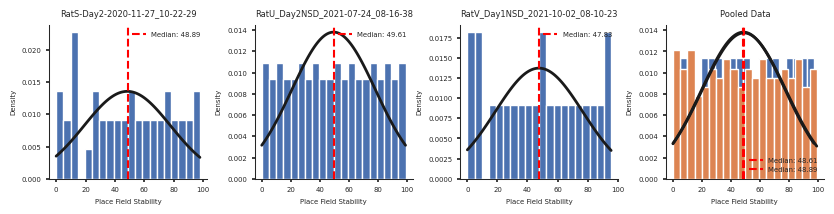

In [107]:

# Set up the figure and subplots
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10,2))

# Plot the three histograms
for i, session_idx in enumerate(range(number_of_sessions)):

    session_number = current_sessions[session_idx]
    session_name = rr[session_number]
    
    ax = axes[i]
    ax.hist(place_field_stability_maze[session_idx][stable_above_1Hz_PF_unit_index[session_idx]], bins=20, density=True)
    ax.set_title(session_name)
    ax.set_xlabel('Place Field Stability')
    ax.set_ylabel('Density')

    # Calculate Gaussian fit
    mu, std = norm.fit(place_field_stability_maze[session_idx][stable_above_1Hz_PF_unit_index[session_idx]])
    x = np.linspace(min(place_field_stability_maze[session_idx][stable_above_1Hz_PF_unit_index[session_idx]]), max(place_field_stability_maze[session_idx][stable_above_1Hz_PF_unit_index[session_idx]]), 100)
    p = norm.pdf(x, mu, std)
    ax.plot(x, p, 'k', linewidth=2)

    # Add vertical line for median
    median = np.median(place_field_stability_maze[session_idx][stable_above_1Hz_PF_unit_index[session_idx]])
    ax.axvline(median, linestyle='--', color='red', label=f'Median: {median:.2f}')
    ax.legend()
    

# Plot the pooled data histogram
ax = axes[3]
ax.hist(place_field_stability_maze_concat[stable_above_1Hz_PF_unit_index_session_concat], bins=20, density=True)
ax.set_title('Pooled Data')
ax.set_xlabel('Place Field Stability')
ax.set_ylabel('Density')

# Calculate Gaussian fit
mu, std = norm.fit(place_field_stability_maze_concat[stable_above_1Hz_PF_unit_index_session_concat])
x = np.linspace(min(place_field_stability_maze_concat[stable_above_1Hz_PF_unit_index_session_concat]), max(place_field_stability_maze_concat[stable_above_1Hz_PF_unit_index_session_concat]), 100)
p = norm.pdf(x, mu, std)
ax.plot(x, p, 'k', linewidth=2)

# Add vertical line for median
median = np.median(place_field_stability_maze_concat[stable_above_1Hz_PF_unit_index_session_concat])
ax.axvline(median, linestyle='--', color='red', label=f'Median: {median:.2f}')
ax.legend()

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.3)

# Save the figure
filename = 'place_field_stability_histograms.pdf'
file_path = os.path.join(main_dir, filename)
# plt.savefig(file_path, dpi=300)


### Test if the main reason that the POST LTs predict the reMAZE PFs beyond MAZE PF is because both POST LTs and reMAZE PFs are noisy
#### To asnwer this question we can do two analyses:
#### (1) The correlation between the POST LTs Gini coefficient and its correlation with the reMAZE PFs across units
#### (2) The distribution of spatial information in MAZE and reMAZE

/tmp/ipykernel_106559/1405232100.py:7: RuntimeWarning: invalid value encountered in double_scalars
  rmad = mad/np.mean(x)
/tmp/ipykernel_106559/1405232100.py:139: DeprecationWarning: Please use `linregress` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  slope, intercept, r_value, p_value, std_err = stats.linregress(


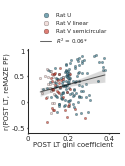

In [39]:
import numpy as np

def gini(x):
    # Mean absolute difference 
    mad = np.abs(np.subtract.outer(x,x)).mean()
    # Relative mean absoulte difference 
    rmad = mad/np.mean(x)
    # Gini coefficient 
    g = 0.5*rmad
    return g


# def gini(x):
#     sorted_x = np.sort(x)
#     n = sorted_x.shape[0]
#     # cumulative_sum = np.cumsum(sorted_x)

#     gini_sum = n + 1 - 2*np.nansum((n+1-np.arange(1, n+1))*sorted_x)/np.nansum(sorted_x)
#     gini_coeff = gini_sum / (n-1)
#     return gini_coeff


learned_tunings_before_normalization_session_concat = dict.fromkeys(epoch_names)
for epoch, epoch_name in enumerate(epoch_names):
    temp = []
    for session_idx in range(number_of_sessions):
        temp.append(learned_tunings_before_normalization[session_idx][epoch_name])
    learned_tunings_before_normalization_session_concat[epoch_name] = np.concatenate(temp, axis = 0)


# Calculate Gini coefficients for each row
current_LT = learned_tunings_before_normalization_session_concat['post']
learned_tunings_gini = np.array([gini(row) for row in current_LT])

# # Print the Gini coefficients
# for i, g in enumerate(learned_tunings_gini):
#     print(f"Row {i + 1}: Gini Coefficient = {g:.2f}")


#--------------------------------------------------------------------------------------------------------------------------------------------------
# Scatter plot

unit_subset_index = stable_above_1Hz_PF_unit_index_session_concat


# ---------------------------------------------------------------------------------------------------------------------------------------------------------------
# Define functions

def get_pval_statement(pvalue):
    
    if pvalue <= 0.0001:
        pvalue_statement = '***'
    elif pvalue < 0.001:
        pvalue_statement = '**'
    elif pvalue < 0.01:
        pvalue_statement = '*'
    else:
        pvalue_statement = f'P={pvalue:.2f}'
    
    return pvalue_statement

def format_ticks(x, _):
    if x == int(x):
        return str(int(x))
    else:
        return str(x)

#-----------------------------------------------------------------------------------------------------------------------------------------------------------------
# Set up figure colors and style


sns.set_style('whitegrid') 
sns.set_context('paper')

custom_params = {
    "axes.spines.top": False,
    "axes.spines.right": False
    }

sns.set_theme(style="ticks", rc=custom_params)

plt.rcParams.update({
    'font.size':6,
    'axes.linewidth':0.75,
    'pdf.fonttype':42,
    'ps.fonttype':42,
    'axes.labelsize':6,
    'axes.titlesize':8,
    'xtick.labelsize':5,
    'ytick.labelsize':5,
    'legend.fontsize':6,
    'legend.title_fontsize':6,
    'legend.frameon': False,
    'legend.markerscale':2,
    'xtick.major.size':2,
    'ytick.major.size':2
})

cmap = sns.diverging_palette(220, 15)
session_specific_colors = [cmap[i] for i in [0, 3, 5]]


#-------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Generate the figure

plotheight = 120
plotwidth = 90
font_size = 5

fig = plt.figure()
fig.set_size_inches([plotwidth/72, plotheight/72])
gs = GridSpec(nrows=1, ncols=1, figure=fig, hspace=0.3, wspace=0.5)

ax = fig.add_subplot(gs[0])


# Scatterplot

for session_idx, session_number in enumerate(current_sessions):
    session_name = rr[session_number]
    unit_subset_current_session = np.where(unit_subset_index & np.isin(each_unit_session_number_session_concat, session_number))[0] # & (place_field_stability_maze_concat < 50)
    sns.scatterplot(
        x=learned_tunings_gini[unit_subset_current_session],
        y=learned_tunings_remaze_place_field_corr_sessions_concat['post'][unit_subset_current_session],
        color = session_specific_colors[session_idx],
        marker='o',
        edgecolor = 'black',
        linewidth=0.2, 
        s=3, 
        alpha=0.7, 
        ax=ax, 
        label = session_name_mapping[session_name]
        )


# Add the regression line
reg_valid_idx = ~np.isnan(learned_tunings_gini) & ~np.isnan(learned_tunings_remaze_place_field_corr_sessions_concat['post'])

slope, intercept, r_value, p_value, std_err = stats.linregress(
    learned_tunings_gini[unit_subset_index & reg_valid_idx],
    learned_tunings_remaze_place_field_corr_sessions_concat['post'][unit_subset_index & reg_valid_idx]
    )
sns.regplot(x=learned_tunings_gini[unit_subset_index], y=learned_tunings_remaze_place_field_corr_sessions_concat['post'][unit_subset_index], ci=95, color='black', scatter=False,
            label=f'$R^{2}$ = {r_value**2:.2f}{get_pval_statement(p_value)}',
            line_kws={"linewidth":0.75, "alpha":0.6},
            ax=ax)

ax.set_xlim([0, 0.45])
ax.set_ylim([-0.6, 1.02])

ax.set_ylabel("r(POST LT, reMAZE PF)", fontsize=font_size, labelpad=1)
ax.set_xlabel("POST LT gini coefficient", fontsize=font_size, labelpad=0)

ax.tick_params(axis='both', which='major', length=1, pad=1, width=1)

ax.legend(fontsize=4, loc="upper center", bbox_to_anchor=(0.5, 1.5))

# Format the tick labels using the custom formatter
ax.xaxis.set_major_formatter(FuncFormatter(format_ticks))
ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))

# Adjust the plot layout
plt.subplots_adjust(left=0.22, right= 0.95, bottom=0.2, top=0.70)


filename = 'scatter_plot_POST_LT_gini_vs_remaze_PF_correlation.pdf'
file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, dpi=300)

plt.show()




### Multiple regression to analyze the extent to which the learned tunings calculated during each epoch predicts the reMAZE place fields

In [40]:
# unit_subset = np.where(place_field_stability_maze_concat > -np.inf)[0] # np.percentile(place_field_stability_maze_concat, 5)

# # To split the population of units in terms of each unit's POST LT fidelity
# pf_correlation_median = np.nanmedian(learned_tunings_place_field_corr_sessions_concat['post'])
# unit_subset = np.where(learned_tunings_place_field_corr_sessions_concat['post'] < pf_correlation_median)[0] # np.percentile(place_field_stability_maze_concat, 5)

r2_loo = np.full((number_of_sessions+1,), np.nan)
p_r2_loo = np.full((number_of_sessions+1,), np.nan)
coeffs_loo = [[] for _ in range(number_of_sessions+1)]
p_coeffs_loo = [[] for _ in range(number_of_sessions+1)]
intercept_loo = np.full((number_of_sessions+1,), np.nan)

# current_sessions = [7, 8, 9, 10] #  
# current_sessions = list(np.setdiff1d(current_sessions, [7]))

if ~np.isin(999, current_sessions):
    current_sessions.append(999) # 999 is not among the sessions, but adding it enables us to calculate the pooled result without exclluding any of the actual sessions

print(current_sessions)

for excluded_session_idx, excluded_session in enumerate(current_sessions):
    
    included_sessions = np.setdiff1d(current_sessions, excluded_session)
    # unit_subset = np.where(np.isin(each_unit_session_number_sessions_concat, included_sessions))[0] # & (place_field_stability_maze_concat < 50)

    unit_subset = np.where(
        np.isin(each_unit_session_number_session_concat, included_sessions) &
        stable_above_1Hz_PF_unit_index_session_concat
        # (learned_tunings_place_field_corr_sessions_concat['post'] < np.nanpercentile(learned_tunings_place_field_corr_sessions_concat['post'], 50)) & 
        # (post_learned_tunings_stability_session_concat > np.nanpercentile(post_learned_tunings_stability_session_concat, 50))
        )[0]


    DV = spatial_tunings_remaze_sessions_concat[unit_subset] # dependent variable 
    # DV = learned_tunings_sessions_concat['remaze_theta'][unit_subset]  


    average_Y  = np.nanmean(np.concatenate([learned_tunings_sessions_concat['pre'][unit_subset] ,learned_tunings_sessions_concat['post'][unit_subset]], axis = 0), axis = 0)
    average_Y  = (average_Y - np.nanmean(average_Y))/np.nanstd(average_Y)
    background = np.tile(average_Y, [DV.size // average_Y.size, 1])

    predictors       = np.concatenate(
        (background.flatten()[:, np.newaxis],
        learned_tunings_sessions_concat['pre'][unit_subset].flatten()[:, np.newaxis], 
        spatial_tunings_maze_sessions_concat[unit_subset].flatten()[:, np.newaxis], 
        #  learned_tunings_sessions_concat['maze_theta'][unit_subset].flatten()[:, np.newaxis], 
        #  learned_tunings_sessions_concat['maze'][unit_subset].flatten()[:, np.newaxis], 
        learned_tunings_sessions_concat['post'][unit_subset].flatten()[:, np.newaxis],
        # learned_tunings_sessions_concat['post_nrem'][unit_subset].flatten()[:, np.newaxis],
        # learned_tunings_sessions_concat['post_qw'][unit_subset].flatten()[:, np.newaxis],
        learned_tunings_sessions_concat['post_late'][unit_subset].flatten()[:, np.newaxis]
        ),
        axis=1)

    predictor_labels = [ 
        'average LT', 
        'PRE LTs',
        'MAZE PFs',
        # 'MAZE theta LTs',
        # 'MAZE ripple LTs',
        'POST LTs',
        # 'POST NREM LTs',
        # 'POST QW LTs',
        'latePOST LTs'
    ] # add 'intercept' to the labels for plotting


    num_predictors = len(predictor_labels)


    non_nan_idx = np.where(~np.isnan(DV.flatten()) & ~np.isnan(np.sum(predictors, axis = 1)))[0]

    lm     = LinearRegression().fit(predictors[non_nan_idx], DV.flatten()[non_nan_idx])
    r2_loo[excluded_session_idx] = lm.score(predictors[non_nan_idx], DV.flatten()[non_nan_idx])
    coeffs_loo[excluded_session_idx] = lm.coef_
    intercept_loo[excluded_session_idx] = lm.intercept_


    # Comapring the R^2 and regression coefficients to shuffles
    num_shuffles = 10000

    # stable_indexes = np.concatenate((np.where(stable_below_1Hz_PF_unit_index_session_concat)[0], np.where(stable_above_1Hz_PF_unit_index_session_concat)[0]), axis = 0)
    # DV_all = spatial_tunings_remaze_sessions_concat[stable_indexes]
    # DV_all = learned_tunings_sessions_concat['remaze_theta'][stable_indexes]
    
    r2_shuffle     = np.zeros(num_shuffles)
    coeffs_shuffle = np.zeros((num_predictors, num_shuffles))

    for shuffle_idx in range(num_shuffles):

        DV_randomized = DV[np.random.permutation(DV.shape[0]), :] # randomizing the units indices in the dependent variable (e.g., REMAZE place fields)

        non_nan_idx = np.where(~np.isnan(DV_randomized.flatten()) & ~np.isnan(np.sum(predictors, axis = 1)))[0]

        shuffle_lm    = LinearRegression().fit(predictors[non_nan_idx], DV_randomized.flatten()[non_nan_idx])
        r2_shuffle[shuffle_idx]        = shuffle_lm.score(predictors[non_nan_idx], DV_randomized.flatten()[non_nan_idx])
        coeffs_shuffle[:, shuffle_idx] = shuffle_lm.coef_

    p_r2_loo[excluded_session_idx]     = (r2_loo[excluded_session_idx] < r2_shuffle).sum() / num_shuffles
    p_coeffs_loo[excluded_session_idx] = (coeffs_loo[excluded_session_idx].reshape(-1, 1) < coeffs_shuffle).sum(axis=1) / num_shuffles



[8, 9, 10, 999]


In [45]:
p_coeffs_loo
# intercept_loo
# coeffs_loo

[array([9.993e-01, 7.165e-01, 4.000e-04, 4.460e-02, 1.315e-01]),
 array([1.000e+00, 6.300e-01, 0.000e+00, 2.000e-04, 6.845e-01]),
 array([1.    , 0.8057, 0.    , 0.    , 0.4956]),
 array([1.    , 0.7691, 0.    , 0.    , 0.5864])]

/home/kouroshmaboudi/miniconda3/envs/learned_tuning_project_env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1062: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


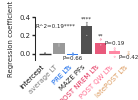

In [28]:
def get_pval_statement(pvalue):
    
    if pvalue <= 0.0001:
        pvalue_statement = '****'
    elif pvalue < 0.001:
        pvalue_statement = '***'
    elif pvalue < 0.01:
        pvalue_statement = '**'
    elif pvalue < 0.05:
        pvalue_statement = '*'
    else:
        pvalue_statement = f'P={pvalue:.2f}'
    
    return pvalue_statement


#------------------------------------------------------------------------------------------------------------
# Set up colors ans styles

sns.set_style('whitegrid') # Set style and context
sns.set_context('paper')

custom_params = {"axes.spines.top": False, "axes.spines.right": False}
sns.set_theme(style="ticks", rc=custom_params)

plt.rcParams.update({
    'font.size':6,
    'axes.linewidth':0.75,
    'pdf.fonttype':42,
    'ps.fonttype':42,
    'axes.labelsize':6,
    'axes.titlesize':8,
    'xtick.labelsize':6,
    'ytick.labelsize':5,
    'legend.fontsize':6,
    'legend.title_fontsize':6,
    'legend.frameon': False,
    'legend.markerscale':2,
    'xtick.major.size':2,
    'ytick.major.size':2
})

colors = [
    '#005CE9', # PRE
    '#DD335D' # POST
    ] 

plotheight = 72
plotwidth = 100 #90
font_size = 5

fig = plt.figure()
fig.set_size_inches([plotwidth/72, plotheight/72])
gs = GridSpec(nrows=1, ncols=1, figure=fig, hspace=0.3, wspace=0.5)


colors = [
    'black', # intercept
    [.5,.5,.5], # background
    '#005CE8', # PRE learned tunings
    [0.1490, 0.1490,  0.1490], # MAZE place fields
    # [0.2039, 0.3843, 0.1882], # MAZE theta learned tunings
    # [0.0627, 0.5451, 0.2667], # MAZE ripple learned tunings
    # '#DC335D', # POST learned tunings
    '#E3305A', # POST NREM learned tunings
    '#FF6B8E', # POST QW learned tunings
    '#DC9A5D' # late POST learned tunings
    ]


ax = fig.add_subplot(gs[0])


h = ax.bar(np.arange(num_predictors+1), np.concatenate([[intercept_loo[-1]], coeffs_loo[-1]]), align='center', alpha=0.8, linewidth=0, color=colors)
for ih in range(1):
    h[ih].set_facecolor('none')
    h[ih].set_edgecolor('black')
    h[ih].set_linewidth(1)

for exluded_session_index, excluded_session in enumerate(current_sessions[:-1]):
    ax.scatter(np.arange(num_predictors+1), np.concatenate([[intercept_loo[exluded_session_index]], coeffs_loo[exluded_session_index]]), s = 1, color='white', edgecolors=colors, alpha=0.9, linewidth=0.25)


for ih in range(3,num_predictors+1):
    h[ih].set_edgecolor('none')

for ip in range(1, num_predictors):
    ax.text(ip+1, coeffs_loo[-1][ip]+0.06*np.sign(coeffs_loo[-1][ip]), get_pval_statement(p_coeffs_loo[-1][ip]), horizontalalignment='center', fontsize = 4)

ax.text(0.75, 0.3, f'R^2={r2_loo[-1]:.2f}{get_pval_statement(p_r2_loo[-1])}', horizontalalignment='center', verticalalignment='center', fontsize = 4)

ax.set_xticks(np.arange(num_predictors+1))
# ax.set_xticks([])
ax.set_xticklabels(np.concatenate([['intercept'], predictor_labels]), fontsize=font_size, ha='right', va='top')
ax.tick_params(axis = 'x', rotation=45)
ax.tick_params(axis = 'both')
for i , label in enumerate(ax.get_xticklabels()):
    label.set_color(colors[i])


# ax.set_ylabel('reMAZE place fields\nregression coeffs', fontsize=font_size)
ax.set_ylabel('Regression coefficient', fontsize=font_size)
ax.set_ylim([-0.07, 0.40])


# ax.set_yticks([0, .1, .2, .3, 0.4, 0.5])
# ax.yaxis.grid(True)

# ax.spines['left'].set_linewidth(2)
# ax.spines['bottom'].set_linewidth(2)

ax.tick_params(axis='both', which='major', length=2, pad=1, width=1)

ax.tick_params(bottom=False)
ax.spines['bottom'].set_visible(False)


plt.subplots_adjust(left=0.25, right= 1, bottom=0.4, top=0.83)


filename = 'multiple_regression_reMAZE_PF_vs_POST_NREM_and_QW_LTs_together.pdf'
# filename = 'multiple_regression_reMAZE_PF_vs_POST_LTs.pdf'
file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, dpi=300)

plt.show()


### Left-over units
left-over units: MAZE peak PF < 1Hz but still stable during the entire session

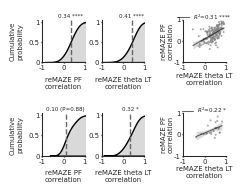

In [119]:

# Behavior of left-over units with peak MAZE place field < 1 HZ
# Quantify stability and their similarity with the reMAZE place field or theta learned tuning 
# Calculate the distribution of POST LT with reMAZE PF and quantify this correlation for the cells with MAZE peak place field below 1Hz. 

# Panels of the figure:
# (1) Stability of the post learned tuning (during the first 4 hours of post)
# (2) Correlation with reMAZE place fields
# (3) Correlation with reMAZE theta LTs


unit_subsets = [stable_above_1Hz_PF_unit_index_session_concat, stable_below_1Hz_PF_unit_index_session_concat]
subset_titles = ['Peak PF > 1 Hz', 'Peak PF < 1 Hz']

curr_epoch = 'post'


#---------------------------------------------------------------------------------------------------------
# Define functions
def format_ticks(x, _):
    if x == int(x):
        return str(int(x))
    else:
        return str(x)

def get_pval_statement(pvalue):
    if pvalue <= 0.0001:
        pvalue_statement = '****'
    elif pvalue <= 0.001:
        pvalue_statement = '***'
    elif pvalue < 0.01:
        pvalue_statement = '**'
    elif pvalue < 0.05:
        pvalue_statement = '*'
    else:
        pvalue_statement = f'(P={pvalue:.2f})'
    return pvalue_statement

#------------------------------------------------------------------------------------------------------------
# Set up colors ans styles

sns.set_style('whitegrid') # Set style and context
sns.set_context('paper')

custom_params = {"axes.spines.top": False, "axes.spines.right": False}
sns.set_theme(style="ticks", rc=custom_params)

plt.rcParams.update({
    'font.size':6,
    'axes.linewidth':0.75,
    'pdf.fonttype':42,
    'ps.fonttype':42,
    'axes.labelsize':5,
    'axes.titlesize':6,
    'xtick.labelsize':5,
    'ytick.labelsize':5,
    'legend.fontsize':5,
    'legend.title_fontsize':6,
    'legend.frameon': False,
    'legend.markerscale':2,
    'xtick.major.size':2,
    'ytick.major.size':2
})

colors = [
    '#005CE9', # PRE
    '#DD335D' # # POST
    ] 

plotheight = 140
plotwidth = 250
font_size = 5

fig = plt.figure()
fig.set_size_inches([plotwidth/72, plotheight/72])
gs = GridSpec(nrows=2, ncols=5, figure=fig, width_ratios=[1, 1, 1, 0.1, 1], wspace=0.5, hspace=1.2)


for unit_subset_index, unit_subset in enumerate(unit_subsets):

    
    #-------------------------------------------------------------------------------------------------------------------------
    # (1) Stability of the post learned tuning (during the first 4 hours of post)
    
    # ax_0 = fig.add_subplot(gs[unit_subset_index, 0])

    # sns.kdeplot(post_learned_tunings_stability_session_concat[unit_subset], cumulative=True, bw_method = 0.6, fill=True, color='black', linestyle= '-', linewidth=1, ax= ax_0, alpha=0.15)


    # stability_median = np.nanmedian(post_learned_tunings_stability_session_concat[unit_subset])
    # _,p_value = wilcoxon(post_learned_tunings_stability_session_concat[unit_subset])
    

    # ax_0.axvline(x=stability_median, color=(.4,.4,.4), linestyle = '--', linewidth=1)
    # yl = ax_0.get_ylim()
    # ax_0.text(stability_median, 1.05*yl[1], f'{stability_median:.2f} {get_pval_statement(p_value)}', ha='center', fontsize=4)

    # ax_0.set_ylim([0,1.05])
    # ax_0.set_xlim([ax_0.get_xlim()[0], ax_0.get_xlim()[1]-3])

    # ax_0.tick_params(axis='both', which='major', length=1, width=1, pad=1)
    # ax_0.xaxis.set_major_formatter(FuncFormatter(format_ticks))
    # ax_0.yaxis.set_major_formatter(FuncFormatter(format_ticks))


    # ax_0.set_xlabel("Stability\n(Z-score)")
    # ax_0.set_ylabel("Cumulative\nprobability")
    # ax_0.set_title(subset_titles[unit_subset_index], loc = 'left', fontsize = 6)


    #-------------------------------------------------------------------------------------------------------------------------
    # (2) Correlation with reMAZE place fields
    ax_1 = fig.add_subplot(gs[unit_subset_index,1])

    # LT_remaze_PF_similarity, _, midian_stats = calculate_place_field_fidelity_of_learned_tuning(learned_tunings_sessions_concat['pre'][unit_subset], spatial_tunings_remaze_sessions_concat[unit_subset], num_shuffles)

    # LT_remaze_PF_similarity_median = midian_stats['data']
    # LT_remaze_PF_similarity_median_pval = midian_stats['p_value']


    sns.kdeplot(learned_tunings_remaze_place_field_corr_sessions_concat[curr_epoch][unit_subset], cumulative=True, bw_method= 0.6, fill=True, color='black', linestyle= '-', linewidth=1, ax= ax_1, alpha=0.15)


    current_median = np.nanmedian(learned_tunings_remaze_place_field_corr_sessions_concat[curr_epoch][unit_subset])
    current_medians_shuffle = np.nanmedian(learned_tunings_remaze_place_field_corr_unit_id_shuffle_concat[curr_epoch][unit_subset], axis = 0)
    current_pvalue = np.sum(current_medians_shuffle >= current_median)/current_medians_shuffle.shape[0]

    ax_1.axvline(x=current_median, color=(.4,.4,.4), linestyle = '--', linewidth=1)
    
    yl = ax_1.get_ylim()
    ax_1.text(current_median, 1.05*yl[1], f'{current_median:.2f} {get_pval_statement(current_pvalue)}', ha='center', fontsize=4)

    ax_1.set_xlim([-1,1])
    ax_1.set_ylim([0,1.05])

    ax_1.set_xlabel("reMAZE PF\ncorrelation")
    # ax_1.set_ylabel("")
    ax_1.set_ylabel("Cumulative\nprobability")


    ax_1.tick_params(axis='both', which='major', length=1, width=1, pad=1)
    ax_1.xaxis.set_major_formatter(FuncFormatter(format_ticks))
    ax_1.yaxis.set_major_formatter(FuncFormatter(format_ticks))



    #-----------------------------------------------------------------------------------------------------------------------------
    # (3) Correlation with reMAZE theta LTs
    ax_2 = fig.add_subplot(gs[unit_subset_index,2])


    # LT_remaze_theta_LT_similarity, _, midian_stats = calculate_place_field_fidelity_of_learned_tuning(learned_tunings_sessions_concat['pre'][unit_subset], learned_tunings_sessions_concat['remaze_theta'][unit_subset], num_shuffles)

    # LT_remaze_theta_LT_similarity_median = midian_stats['data']
    # LT_remaze_theta_LT_similarity_median_pval = midian_stats['p_value']

    sns.kdeplot(learned_tunings_remaze_theta_corr_sessions_concat[curr_epoch][unit_subset], cumulative=True, bw_method = 0.6, fill=True, color='black', linestyle= '-', linewidth=1, ax= ax_2, alpha=0.15)

    current_median = np.nanmedian(learned_tunings_remaze_theta_corr_sessions_concat[curr_epoch][unit_subset])
    current_medians_shuffle = np.nanmedian(learned_tunings_remaze_theta_corr_unit_id_shuffle_concat[curr_epoch][unit_subset], axis = 0)
    current_pvalue = np.sum(current_medians_shuffle >= current_median)/num_shuffles

    ax_2.axvline(x=current_median, color=(.4,.4,.4), linestyle = '--', linewidth=1)
    yl = ax_2.get_ylim()
    ax_2.text(current_median, 1.05*yl[1], f'{current_median:.2f} {get_pval_statement(current_pvalue)}', ha='center', fontsize=4)

    ax_2.set_xlim([-1,1])
    ax_2.set_ylim([0,1.05])

    ax_2.set_xlabel("reMAZE theta LT\ncorrelation")
    ax_2.set_ylabel("")


    ax_2.tick_params(axis='both', which='major', length=1, width=1, pad=1)
    ax_2.xaxis.set_major_formatter(FuncFormatter(format_ticks))
    ax_2.yaxis.set_major_formatter(FuncFormatter(format_ticks))



    #--------------------------------------------------------------------------------------------------------------------------------
    # (4) Correlation between POST LTs prediction of remaze PF and remaze theta LT 
    ax_3 = fig.add_subplot(gs[unit_subset_index,4])

    x = learned_tunings_remaze_theta_corr_sessions_concat[curr_epoch][unit_subset]
    y = learned_tunings_remaze_place_field_corr_sessions_concat[curr_epoch][unit_subset]

    # Remove NaN values
    valid_index = np.where(~np.isnan(x) & ~np.isnan(y))[0]
    x = x[valid_index]
    y = y[valid_index]

    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    line = slope * x + intercept


    sns.scatterplot(
            x=x,
            y=y,
            color = 'gray',
            marker='o',
            edgecolor = 'none',
            linewidth=0, 
            s=2, 
            alpha=0.7, 
            ax=ax_3, 
            )


    # Add the best-fit line
    sns.regplot(x=x, y=y, ci=95, color='black', scatter=False,
                label=f'$R^{2}$={r_value**2:.2f} {get_pval_statement(p_value)}',
                line_kws={"linewidth":0.75, "alpha":0.6},
                ax=ax_3)

    ax_3.set_xlim([-1, 1])
    ax_3.set_ylim([-1, 1])

    ax_3.set_xlabel("reMAZE theta LT\ncorrelation", fontsize=font_size, labelpad=1)
    ax_3.set_ylabel("reMAZE PF\ncorrelation", fontsize=font_size, labelpad=0)

    ax_3.tick_params(axis='both', which='major', length=1, pad=1, width=1)
    ax_3.xaxis.set_major_formatter(FuncFormatter(format_ticks))
    ax_3.yaxis.set_major_formatter(FuncFormatter(format_ticks))
    

    ax_3.legend(fontsize=4, loc="upper center", bbox_to_anchor=(0.5, 1.3))



plt.subplots_adjust(left=0.2, right= 0.9, bottom=0.2, top=0.9)


# filename = 'left_over_units_remaze_prediction_latePOST.pdf'
filename = 'test.pdf'
file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)


In [118]:
current_pvalue

0.0241

### Place fields of the neurons during MAZE and reMAZE and the relationship between their firing rates

##### (1) Plot MAZE and reMAZE place fields for all units

/tmp/ipykernel_30492/2467991170.py:58: RuntimeWarning: invalid value encountered in divide
  current_data = current_data / np.amax(current_data, axis=1, keepdims=True)
/tmp/ipykernel_30492/2467991170.py:79: RuntimeWarning: invalid value encountered in divide
  current_data = current_data / np.amax(current_data, axis=1, keepdims=True)
/tmp/ipykernel_30492/2467991170.py:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(w_pad=0.2)


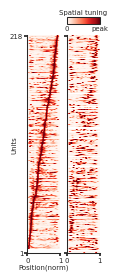

In [14]:
import seaborn_image as isns

# unit_subset = stable_above_1Hz_PF_unit_index_session_concat
# unit_subset = np.arange(spatial_tunings_maze_sessions_concat.shape[0])
unit_subset_index = np.concatenate(stable_unit_index, axis=0)
num_curr_units = np.where(unit_subset_index)[0].shape[0]

#------------------------------------------------------------------------------------------------------------
# Set up colors ans styles

sns.set_style('whitegrid') # Set style and context
sns.set_context('paper')

custom_params = {"axes.spines.top": False, "axes.spines.right": False}
sns.set_theme(style="ticks", rc=custom_params)

plt.rcParams.update({
    'font.size':6,
    'axes.linewidth':0.75,
    'pdf.fonttype':42,
    'ps.fonttype':42,
    'axes.labelsize':5,
    'axes.titlesize':6,
    'xtick.labelsize':5,
    'ytick.labelsize':5,
    'legend.fontsize':5,
    'legend.title_fontsize':5,
    'legend.frameon': False,
    'legend.markerscale':2,
    'xtick.major.size':2,
    'ytick.major.size':2
})



#---------------------------------------------------------------------------------------------------------------
# Create figure and subplots

plotheight = 200
plotwidth = 80
font_size = 6

fig = plt.figure()
fig.set_size_inches([plotwidth/72, plotheight/72])
gs = GridSpec(nrows=2, ncols=2, height_ratios=[0.03, 0.97], hspace=0.1, figure=fig)


# MAZE place fields
ax0 = fig.add_subplot(gs[1,0])
spatial_tunings_maze_before_normalization_sessions_concat = np.concatenate(spatial_tunings_maze_before_normalization, axis = 0)
current_spatial_tunings_maze = spatial_tunings_maze_before_normalization_sessions_concat[unit_subset_index]

place_fields_peak_locations = np.argmax(current_spatial_tunings_maze, axis=1)
place_fields_sort_idx = np.argsort(place_fields_peak_locations)


current_data = current_spatial_tunings_maze[place_fields_sort_idx]
current_data = current_data / np.amax(current_data, axis=1, keepdims=True)
isns.imgplot(current_data, cmap='Reds', interpolation='nearest', origin = 'lower', cbar=False, ax=ax0)
# ax0.imshow(spatial_tunings_maze_sessions_concat, cmap='plasma', interpolation='nearest', origin = 'lower')
ax0.set_aspect("auto")

ax0.set_xticks([0, num_pos_bins_interp], [0, 1])
ax0.set_yticks([0, num_curr_units-1], [1, num_curr_units])

ax0.set_xlabel('Position(norm)', labelpad=0)
ax0.set_ylabel('Units', labelpad=-5)

ax0.tick_params(pad=1)



# reMAZE place fields
ax1 = fig.add_subplot(gs[1,1])
spatial_tunings_remaze_before_normalization_sessions_concat = np.concatenate(spatial_tunings_remaze_before_normalization, axis = 0)
current_spatial_tunings_remaze = spatial_tunings_remaze_before_normalization_sessions_concat[unit_subset_index]

current_data = current_spatial_tunings_remaze[place_fields_sort_idx]
current_data = current_data / np.amax(current_data, axis=1, keepdims=True)

isns.imgplot(current_data, cmap='Reds', interpolation='nearest', origin = 'lower', cbar=False, ax=ax1)
# ax1.imshow(spatial_tunings_remaze_sessions_concat, cmap='plasma', interpolation='nearest', origin = 'lower')
ax1.set_aspect("auto")

ax1.set_xticks([0, num_pos_bins_interp], [0, 1])
ax1.set_yticks([0, num_curr_units-1], [])

ax1.tick_params(pad=1)



ax2 = fig.add_subplot(gs[0,1])
cbar = plt.colorbar(ax1.get_images()[0], cax=ax2, orientation='horizontal', drawedges= False)
cbar.set_label("Spatial tuning", labelpad=2)
cbar.set_ticks([0, 1])
cbar.set_ticklabels([0, 'peak'])
cbar.ax.tick_params(length=0, pad=1)
cbar.ax.xaxis.set_label_position('top')

plt.tight_layout(w_pad=0.2)
plt.subplots_adjust(left=0.2, right= 0.85, bottom=0.10, top=0.95, hspace=0.1)


filename = 'maze_remaze_place_fields.pdf'
file_path = os.path.join(main_dir, filename)
# plt.savefig(file_path, format='pdf', dpi=300)




##### (2) Plot MAZE verus reMAZE peak place field firing rates 

In [ ]:
#--------------------------------------------------------------------------------------------------------------------------------------------
# Extract peak place fields for MAZE and reMAZE for the unit with stable firings
maze_peak_place_fields = np.amax(spatial_tunings_maze_before_normalization_sessions_concat[unit_subset_index], axis=1)
remaze_peak_place_fields = np.amax(spatial_tunings_remaze_before_normalization_sessions_concat[unit_subset_index], axis=1)


# # Remove NaN values
# valid_index = np.where(~np.isnan(maze_peak_place_fields) & ~np.isnan(remaze_peak_place_fields))[0]
# maze_peak_place_fields = maze_peak_place_fields[valid_index]
# remaze_peak_place_fields = remaze_peak_place_fields[valid_index]


#---------------------------------------------------------------------------------------------------------------------------------------------
# Define functions

def get_pval_statement(pvalue):
    if pvalue < 0.0001:
        return '***'
    elif pvalue < 0.001:
        return '**'
    elif pvalue < 0.01:
        return '*'
    else:
        return f'P={pvalue:.2f}'

#----------------------------------------------------------------------------------------------------------------------------------------------
# Set plot style and context
sns.set_style('whitegrid') 
sns.set_context('paper')

custom_params = {
    "axes.spines.top": False,
    "axes.spines.right": False
    }

sns.set_theme(style="ticks", rc=custom_params)

plt.rcParams.update({
    'font.size':6,
    'axes.linewidth':0.75,
    'pdf.fonttype':42,
    'ps.fonttype':42,
    'axes.labelsize':6,
    'axes.titlesize':8,
    'xtick.labelsize':5,
    'ytick.labelsize':5,
    'legend.fontsize':5,
    'legend.title_fontsize':6,
    'legend.frameon': False,
    'legend.markerscale':2,
    'xtick.major.size':2,
    'ytick.major.size':2
})

def format_ticks(x, _):
    if x == int(x):
        return str(int(x))
    else:
        return str(x)

#----------------------------------------------------------------------------------------------------------------------------------------------
# Set plot size and create a plot
plotheight = 170
plotwidth = 125
font_size = 6

fig = plt.figure()
fig.set_size_inches([plotwidth/72, plotheight/72])
gs = GridSpec(nrows=3, ncols=3, figure=fig, height_ratios=[0.2, 1, 0.2], width_ratios=[0.1,1,0.2], hspace=0.1, wspace=0.1)


#----------------------------------------------------------------------------------------------------------------------------------------------
# Plot the marginal distributions

# MAZE
ax0 = fig.add_subplot(gs[0, 1])
current_values = np.log10(maze_peak_place_fields)
rr = sns.histplot(current_values, bins=30, cumulative=False, stat='count', kde=True, color='gray', edgecolor='none', line_kws={'linewidth':0.5}, ax = ax0)
ax0.set_xlim(np.log10([0.05, 50]))
ax0.set_xlabel("")
ax0.set_ylabel("Units", fontsize=font_size)
ax0.set_xticklabels([])

# median 
curr_median = np.nanmedian(maze_peak_place_fields)
ax0.axvline(x = np.log10(curr_median), color='gray', linestyle = '--', linewidth=0.75)
ax0.text(np.log10(curr_median), ax0.get_ylim()[1], f'{curr_median:.2f} Hz', fontsize=5)


ax0.tick_params(axis='both', which='major', length=1, pad=1, width=1)
ax0.axvline(x=0, color=(.7,.7,.7), linestyle = '--', linewidth=0.75)


# reMAZE
ax1 = fig.add_subplot(gs[1, 2])
current_values = np.log10(remaze_peak_place_fields)
rr = sns.histplot(y = current_values, bins=30, cumulative=False, stat='count', kde=True, color='gray', edgecolor='none', line_kws={'linewidth':0.5}, orientation="vertical", ax = ax1)
ax1.set_ylim(np.log10([0.05, 50]))
ax1.set_ylabel("")
ax1.set_xlabel("Units", fontsize=font_size)
ax1.set_yticklabels([])

# median
curr_median = np.nanmedian(remaze_peak_place_fields)
ax1.axhline(y = np.log10(curr_median), color='gray', linestyle = '--', linewidth=0.75)
ax1.text(ax1.get_xlim()[1], np.log10(curr_median), f'{curr_median:.2f} Hz', fontsize=5)



ax1.tick_params(axis='both', which='major', length=1, pad=0, width=1)
ax1.axhline(y=0, color=(.7,.7,.7), linestyle = '--', linewidth=0.75)


#---------------------------------------------------------------------------------------------------------------------------------------------------------
# MAZE versus reMAZE scatterplot

ax2 = fig.add_subplot(gs[1,1])

ax2.axhline(y = 1, linestyle='--', color=(0.7,0.7,0.7), linewidth=.75)
ax2.axvline(x = 1, linestyle='--', color=(0.7,0.7,0.7), linewidth=.75)

stable_maze_remaze_place_field_unit_index = (maze_peak_place_fields > 0) & (remaze_peak_place_fields > 0)
sns.scatterplot(
        x=maze_peak_place_fields[stable_maze_remaze_place_field_unit_index],
        y=remaze_peak_place_fields[stable_maze_remaze_place_field_unit_index],
        color = 'gray',
        marker='o',
        edgecolor = 'black',
        linewidth=0.2, 
        s=3, 
        alpha=0.7, 
        ax=ax2, 
        )


#------------------------------------------------------------------------------------------------------------------------------------------------------------
# Add the regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(
    maze_peak_place_fields[stable_maze_remaze_place_field_unit_index],
    remaze_peak_place_fields[stable_maze_remaze_place_field_unit_index]
    )

line = slope * maze_peak_place_fields[stable_maze_remaze_place_field_unit_index] + intercept

sns.regplot(x=maze_peak_place_fields[stable_maze_remaze_place_field_unit_index],
            y=remaze_peak_place_fields[stable_maze_remaze_place_field_unit_index],
            ci=95,
            color='black',
            scatter=False,
            label=f'$R^{2}$ = {r_value**2:.2f}{get_pval_statement(p_value)}',
            line_kws={"linewidth":0.75, "alpha":0.6},
            ax=ax2)


ax2.set_xlim([0.05, 50])
ax2.set_ylim([0.05, 50])

ax2.set_xscale('log')
ax2.set_yscale('log')


ax2.tick_params(axis='both', which='major', length=2, pad=1, width=1)
ax2.tick_params(axis='both', which='minor', length=1, pad=1, width=0.5)

ax2.legend(fontsize=4, loc="upper center", bbox_to_anchor=(0.3, 1.05))


#----------------------------------------------------------------------------------------------------------------------------------------------------------
# Appearing reMAZE firing and place field
ax3 = fig.add_subplot(gs[1,0])
appearing_unit_index = (maze_peak_place_fields == 0) & (remaze_peak_place_fields > 0)
sns.scatterplot( 
        x=maze_peak_place_fields[appearing_unit_index],
        y=remaze_peak_place_fields[appearing_unit_index],
        color = 'blue',
        marker='o',
        edgecolor = 'black',
        linewidth=0.2, 
        s=3, 
        alpha=0.7, 
        ax=ax3, 
        )
ax3.set_ylim([0.05, 50])
ax3.set_xlim([-1, 3])

ax3.set_yscale('log')

ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_visible(False)

ax3.set_xticks([])
ax3.set_yticks([])
ax3.tick_params(axis='both', which='both', bottom=False, left=False)
ax3.set_ylabel("reMAZE peak firing\n(Hz)", fontsize=font_size, labelpad=-5)
ax3.set_facecolor('none')


#-----------------------------------------------------------------------------------------------------------------------------------------------------------
# Disappearing place fields
ax4 = fig.add_subplot(gs[2,1])
disappearing_unit_idx = (maze_peak_place_fields > 0) & (remaze_peak_place_fields == 0)
sns.scatterplot( 
        x=maze_peak_place_fields[disappearing_unit_idx],
        y=remaze_peak_place_fields[disappearing_unit_idx],
        color = 'orange',
        marker='o',
        edgecolor = 'black',
        linewidth=0.2, 
        s=3, 
        alpha=0.7, 
        ax=ax4, 
        )
ax4.set_xlim([0.05, 50])
ax4.set_ylim([-1, 3])

ax4.set_xscale('log')

ax4.spines['bottom'].set_visible(False)
ax4.spines['left'].set_visible(False)

ax4.set_xticks([])
ax4.set_yticks([])
ax4.tick_params(axis='both', which='both', bottom=False, left=False)
ax4.set_xlabel("Maze peak firing\n(Hz)", fontsize=font_size, labelpad=-8)
ax4.set_facecolor('none')



# Adjust the plot layout
plt.subplots_adjust(left=0.22, right= 0.95, bottom=0.2, top=0.7)


filename = 'scatter_plot_maze_remaze_peak_place_field_firing_rates.pdf'
file_path = os.path.join(main_dir, filename)
# plt.savefig(file_path, dpi=300)

plt.show()

##### (3) MAZE versus reMAZE spatial information across units

/tmp/ipykernel_996/3196389489.py:135: DeprecationWarning: Please use `linregress` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  slope, intercept, r_value, p_value, std_err = stats.linregress(


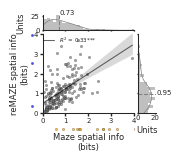

In [138]:
#--------------------------------------------------------------------------------------------------------------------------------------------
# Spatial information for MAZE and reMAZE concatenated across all sessions
spatial_info_maze_session_concatenate = np.concatenate(spatial_info_maze, axis=0)
spatial_info_maze_session_concatenate = spatial_info_maze_session_concatenate[unit_subset_index]

spatial_info_remaze_session_concatenate = np.concatenate(spatial_info_remaze, axis=0)
spatial_info_remaze_session_concatenate = spatial_info_remaze_session_concatenate[unit_subset_index]


# # Remove NaN values
# valid_index = np.where(~np.isnan(maze_peak_place_fields) & ~np.isnan(remaze_peak_place_fields))[0]
# maze_peak_place_fields = maze_peak_place_fields[valid_index]
# remaze_peak_place_fields = remaze_peak_place_fields[valid_index]


#---------------------------------------------------------------------------------------------------------------------------------------------
# Define functions

def get_pval_statement(pvalue):
    if pvalue < 0.0001:
        return '***'
    elif pvalue < 0.001:
        return '**'
    elif pvalue < 0.01:
        return '*'
    else:
        return f'P={pvalue:.2f}'

#----------------------------------------------------------------------------------------------------------------------------------------------
# Set plot style and context
sns.set_style('whitegrid') 
sns.set_context('paper')

custom_params = {
    "axes.spines.top": False,
    "axes.spines.right": False
    }

sns.set_theme(style="ticks", rc=custom_params)

plt.rcParams.update({
    'font.size':6,
    'axes.linewidth':0.75,
    'pdf.fonttype':42,
    'ps.fonttype':42,
    'axes.labelsize':6,
    'axes.titlesize':8,
    'xtick.labelsize':5,
    'ytick.labelsize':5,
    'legend.fontsize':5,
    'legend.title_fontsize':6,
    'legend.frameon': False,
    'legend.markerscale':2,
    'xtick.major.size':2,
    'ytick.major.size':2
})

def format_ticks(x, _):
    if x == int(x):
        return str(int(x))
    else:
        return str(x)

#----------------------------------------------------------------------------------------------------------------------------------------------
# Set plot size and create a plot
plotheight = 170
plotwidth = 125
font_size = 6

fig = plt.figure()
fig.set_size_inches([plotwidth/72, plotheight/72])
gs = GridSpec(nrows=3, ncols=3, figure=fig, height_ratios=[0.2, 1, 0.2], width_ratios=[0.1,1,0.2], hspace=0.1, wspace=0.1)


#----------------------------------------------------------------------------------------------------------------------------------------------
# Plot the marginal distributions

# MAZE
ax0 = fig.add_subplot(gs[0, 1])
current_values = spatial_info_maze_session_concatenate
rr = sns.histplot(current_values, bins=30, cumulative=False, stat='count', kde=True, color='gray', edgecolor='none', line_kws={'linewidth':0.5}, ax = ax0)
ax0.set_xlim([0,4])
ax0.set_xlabel("")
ax0.set_ylabel("Units", fontsize=font_size)
ax0.set_xticklabels([])

# median 
curr_median = np.nanmedian(spatial_info_maze_session_concatenate)
ax0.axvline(x = curr_median, color='gray', linestyle = '--', linewidth=0.75)
ax0.text(curr_median, ax0.get_ylim()[1], f'{curr_median:.2f}', fontsize=5)


ax0.tick_params(axis='both', which='major', length=1, pad=1, width=1)


# reMAZE
ax1 = fig.add_subplot(gs[1, 2])
current_values = spatial_info_remaze_session_concatenate
rr = sns.histplot(y = current_values, bins=30, cumulative=False, stat='count', kde=True, color='gray', edgecolor='none', line_kws={'linewidth':0.5}, orientation="vertical", ax = ax1)
ax1.set_ylim([0,4])
ax1.set_ylabel("")
ax1.set_xlabel("Units", fontsize=font_size)
ax1.set_yticklabels([])

# median
curr_median = np.nanmedian(spatial_info_remaze_session_concatenate)
ax1.axhline(y = curr_median, color='gray', linestyle = '--', linewidth=0.75)
ax1.text(ax1.get_xlim()[1], curr_median, f'{curr_median:.2f}', fontsize=5)


ax1.tick_params(axis='both', which='major', length=1, pad=0, width=1)


#---------------------------------------------------------------------------------------------------------------------------------------------------------
# MAZE versus reMAZE scatterplot

ax2 = fig.add_subplot(gs[1,1])

stable_maze_remaze_place_field_unit_index = (maze_peak_place_fields > 0) & (remaze_peak_place_fields > 0)
sns.scatterplot(
        x=spatial_info_maze_session_concatenate[stable_maze_remaze_place_field_unit_index],
        y=spatial_info_remaze_session_concatenate[stable_maze_remaze_place_field_unit_index],
        color = 'gray',
        marker='o',
        edgecolor = 'black',
        linewidth=0.2, 
        s=3, 
        alpha=0.7, 
        ax=ax2, 
        )


#------------------------------------------------------------------------------------------------------------------------------------------------------------
# Add the regression line
slope, intercept, r_value, p_value, std_err = stats.linregress(
    spatial_info_maze_session_concatenate[stable_maze_remaze_place_field_unit_index],
    spatial_info_remaze_session_concatenate[stable_maze_remaze_place_field_unit_index]
    )

line = slope * spatial_info_maze_session_concatenate[stable_maze_remaze_place_field_unit_index] + intercept

sns.regplot(x=spatial_info_maze_session_concatenate[stable_maze_remaze_place_field_unit_index],
            y=spatial_info_remaze_session_concatenate[stable_maze_remaze_place_field_unit_index],
            ci=95,
            color='black',
            scatter=False,
            label=f'$R^{2}$ = {r_value**2:.2f}{get_pval_statement(p_value)}',
            line_kws={"linewidth":0.75, "alpha":0.6},
            ax=ax2)


ax2.set_xlim([0, 4])
ax2.set_ylim([0, 4])


ax2.tick_params(axis='both', which='major', length=2, pad=1, width=1)
ax2.tick_params(axis='both', which='minor', length=1, pad=1, width=0.5)

ax2.legend(fontsize=4, loc="upper center", bbox_to_anchor=(0.3, 1.05))


#----------------------------------------------------------------------------------------------------------------------------------------------------------
# Appearing reMAZE firing and place field
ax3 = fig.add_subplot(gs[1,0])
sns.scatterplot( 
        x=0,
        y=spatial_info_remaze_session_concatenate[appearing_unit_index],
        color = 'blue',
        marker='o',
        edgecolor = 'black',
        linewidth=0.2, 
        s=3, 
        alpha=0.7, 
        ax=ax3, 
        )
ax3.set_ylim([0, 4])
ax3.set_xlim([-1, 3])

# ax3.set_yscale('log')

ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_visible(False)

ax3.set_xticks([])
ax3.set_yticks([])
ax3.tick_params(axis='both', which='both', bottom=False, left=False)
ax3.set_ylabel("reMAZE spatial info\n(bits)", fontsize=font_size, labelpad=0)
ax3.set_facecolor('none')


#-----------------------------------------------------------------------------------------------------------------------------------------------------------
# Disappearing place fields
ax4 = fig.add_subplot(gs[2,1])
sns.scatterplot( 
        x=spatial_info_maze_session_concatenate[disappearing_unit_idx],
        y=0,
        color = 'orange',
        marker='o',
        edgecolor = 'black',
        linewidth=0.2, 
        s=3, 
        alpha=0.7, 
        ax=ax4, 
        )
ax4.set_xlim([0, 4])
ax4.set_ylim([-1, 3])

# ax4.set_xscale('log')

ax4.spines['bottom'].set_visible(False)
ax4.spines['left'].set_visible(False)

ax4.set_xticks([])
ax4.set_yticks([])
ax4.tick_params(axis='both', which='both', bottom=False, left=False)
ax4.set_xlabel("Maze spatial info\n(bits)", fontsize=font_size, labelpad=0)
ax4.set_facecolor('none')



# Adjust the plot layout
plt.subplots_adjust(left=0.22, right= 0.95, bottom=0.2, top=0.7)


filename = 'scatter_plot_maze_remaze_spatial_information.pdf'
file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, dpi=300)

plt.show()

In [135]:
spatial_info_maze_session_concatenate[disappearing_unit_idx]

array([3.24725392, 2.9081695 , 1.61398161, 1.34274755, 2.64240969,
       1.64772498, 4.06719853, 0.89819582, 2.37729479, 2.64989379,
       0.61101265, 1.49739952])

### Figure 5e, POST LTs for high similarity and low similarity units

In [15]:
five_e_unit_index = dict()
five_e_unit_session = dict()

five_e_unit_index['high_similarity'] = [13, 164, 127, 20, 31, 149, 16, 136, 32,67, 61, 137, 115, 67, 33, 19]
five_e_unit_session['high_similarity'] = [8, 8, 8, 9, 8, 8, 8, 8, 8, 10, 8, 8, 8, 8, 10, 8]

five_e_unit_index['low_similarity'] = [37, 130, 49, 48, 11, 31, 8, 52, 57, 37, 110, 0, 35, 152, 14, 99] 
five_e_unit_session['low_similarity'] = [10, 8, 8, 10, 9, 9, 10, 8, 10, 8, 8, 8, 9, 8, 8, 8]

/tmp/ipykernel_30492/2045806421.py:179: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(w_pad=0.2)


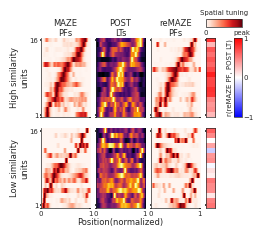

In [16]:
each_unit_session_number_session_concat = np.concatenate(each_unit_session_number, axis=0)
each_unit_within_session_unit_index_session_concat = np.concatenate(each_unit_within_session_unit_index, axis=0)


#------------------------------------------------------------------------------------------------------------
# Set up colors ans styles

sns.set_style('whitegrid') # Set style and context
sns.set_context('paper')

custom_params = {"axes.spines.top": False, "axes.spines.right": False}
sns.set_theme(style="ticks", rc=custom_params)

plt.rcParams.update({
    'font.size':5,
    'axes.linewidth':0.5,
    'pdf.fonttype':42,
    'ps.fonttype':42,
    'axes.labelsize':6,
    'axes.titlesize':6,
    'xtick.labelsize':5,
    'ytick.labelsize':5,
    'legend.fontsize':5,
    'legend.title_fontsize':6,
    'legend.frameon': False,
    'legend.markerscale':2,
    'xtick.major.size':1,
    'ytick.major.size':1
})



#---------------------------------------------------------------------------------------------------------------
# Create figure and subplots

plotheight = 160
plotwidth = 170
font_size = 6

fig = plt.figure()
fig.set_size_inches([plotwidth/72, plotheight/72])
gs = GridSpec(nrows=3, ncols=6, height_ratios=[0.1, 1, 1], width_ratios = [1,1,1, 0.2, 0.15, 0.15], hspace=0.2, wspace=0.2, figure=fig)

all_unit_indexes = np.arange(spatial_tunings_maze_before_normalization_sessions_concat.shape[0])

for condition_index, condition in enumerate(['high_similarity', 'low_similarity']):

    units_to_plot = []
    for unit in range(len(five_e_unit_session[condition])):
        units_to_plot.append(all_unit_indexes[(each_unit_session_number_session_concat == five_e_unit_session[condition][unit]) & (each_unit_within_session_unit_index_session_concat == five_e_unit_index[condition][unit])])
    units_to_plot = np.concatenate(units_to_plot)


    #-------------------------------------------------------------------------------------------------------------------
    # MAZE spatial tunings
    ax0 = fig.add_subplot(gs[condition_index+1,0])

    current_data = spatial_tunings_maze_before_normalization_sessions_concat[units_to_plot]
    current_data = current_data / np.amax(current_data, axis=1, keepdims=True)
    isns.imgplot(current_data, cmap='Reds', interpolation='nearest', origin = 'lower', cbar=False, ax=ax0)
    # ax0.imshow(spatial_tunings_maze_sessions_concat, cmap='plasma', interpolation='nearest', origin = 'lower')
    ax0.set_aspect("auto")
    ax0.set_yticks([0, units_to_plot.shape[0]-1], [1, units_to_plot.shape[0]])

    ax0.set_ylabel(f'{condition.capitalize().replace("_", " ")}\nunits', labelpad=0)

    if condition_index == 0:
        ax0.set_title('MAZE\nPFs', pad=1)

    ax0.set_xticks([0, num_pos_bins_interp-1], [0, 1])
    if condition_index == 0:
        ax0.set_xticklabels([])

    ax0.tick_params(axis='both', which='both', length=1, pad=1)


    #-------------------------------------------------------------------------------------------------------------------
    # reMAZE spatial tunings
    ax1 = fig.add_subplot(gs[condition_index+1,2])

    current_data = spatial_tunings_remaze_before_normalization_sessions_concat[units_to_plot]
    current_data = current_data / np.amax(current_data, axis=1, keepdims=True)

    isns.imgplot(current_data, cmap='Reds', interpolation='nearest', origin = 'lower', cbar=False, ax=ax1)
    # ax1.imshow(spatial_tunings_remaze_sessions_concat, cmap='plasma', interpolation='nearest', origin = 'lower')
    ax1.set_aspect("auto")
    ax1.set_yticks([0, units_to_plot.shape[0]-1], [])


    if condition_index == 0:
        ax1.set_title('reMAZE\nPFs', pad=1)
    
    ax1.set_xticks([0, num_pos_bins_interp-1], [0, 1])
    if condition_index == 0:
        ax1.set_xticklabels([])

    ax1.tick_params(axis='both', which='both', length=1, pad=1)


    #---------------------------------------------------------------------------------------------------------------------
    # POST LTs
    ax3 = fig.add_subplot(gs[condition_index+1,1])

    current_data = learned_tunings_sessions_concat['post'][units_to_plot]
    current_data = [x-np.nanmin(x) for x in current_data]
    current_data = np.array(current_data)

    current_data = current_data / np.amax(current_data, axis=1, keepdims=True)


    isns.imgplot(current_data, cmap='inferno', interpolation='nearest', origin = 'lower', cbar=False, ax=ax3)
    # ax1.imshow(spatial_tunings_remaze_sessions_concat, cmap='plasma', interpolation='nearest', origin = 'lower')
    ax3.set_aspect("auto")
    ax3.set_yticks([0, units_to_plot.shape[0]-1], [])


    if condition_index == 0:
        ax3.set_title('POST\nLTs', pad=1)

    ax3.set_xticks([0, num_pos_bins_interp-1], [0, 1])
    if condition_index == 0:
        ax3.set_xticklabels([])

    ax3.tick_params(axis='both', which='both', length=1, pad=1)

    if condition_index == 1:
        ax3.set_xlabel('Position(normalized)', labelpad=1)

    #-----------------------------------------------------------------------------------------------------------------------
    # Post LT-reMAZE PF correlations
    ax4 =  fig.add_subplot(gs[condition_index+1,3])

    # Calculate the correlation between POST LTs and reMAZE PFs
    post_LT_remaze_PF_corr = np.full((len(units_to_plot), 1), np.nan)
    for unit_index, unit in enumerate(units_to_plot):
        
        curr_post_LT = learned_tunings_sessions_concat['post'][unit]
        curr_remaze_PF = spatial_tunings_remaze_before_normalization_sessions_concat[unit]

        valid_indexes = ~np.isnan(curr_post_LT) & ~np.isnan(curr_remaze_PF)
        post_LT_remaze_PF_corr[unit_index] = np.corrcoef(curr_post_LT[valid_indexes], curr_remaze_PF[valid_indexes])[0, 1]

    isns.imgplot(post_LT_remaze_PF_corr, cmap='bwr',vmin=-1, vmax=1, interpolation='nearest', origin = 'lower', cbar=False, ax=ax4)

    ax4.spines['right'].set_visible(True)
    ax4.spines['top'].set_visible(True)
    ax4.set_aspect('auto')
    ax4.set_yticks([0, units_to_plot.shape[0]-1], [])



# Colorbar for spatial tuning
ax_cbar = fig.add_subplot(gs[0,3:])
cbar = plt.colorbar(ax1.get_images()[0], cax=ax_cbar, orientation='horizontal', drawedges= False)
cbar.set_label("Spatial tuning", labelpad=3, fontsize=5 )
cbar.set_ticks([0, 1])
cbar.set_ticklabels([0, 'peak'])
cbar.ax.tick_params(pad=1)
cbar.ax.xaxis.set_label_position('top')
ax_cbar.tick_params(axis='both', which='both', length=0, pad=2, labelsize=5)

# Colorbar for post LT  remaze PF correlation

ax_cbar = fig.add_subplot(gs[1,5])
cbar = plt.colorbar(ax4.get_images()[0], cax=ax_cbar, orientation='vertical', drawedges= False)
cbar.set_label("r(reMAZE PF, POST LT)", labelpad=1, fontsize=5)
cbar.set_ticks([-1, 0, 1])
cbar.ax.tick_params(pad=1)
cbar.ax.yaxis.set_label_position('left')
ax_cbar.tick_params(axis='both', which='both', length=0, pad=1, labelsize=5)



# Adjust the subplots

plt.subplots_adjust(left=0.05, right= 0.9, bottom=0.10, top=0.95, hspace=0.1)


plt.tight_layout(w_pad=0.2)


filename = 'figure5e_low_and _high_similarity_units.pdf'
file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, format='pdf', dpi=300)




### MAZE/reMAZE similarity vs POST reMAZE correlation


/tmp/ipykernel_996/3002477881.py:101: DeprecationWarning: Please use `linregress` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  slope, intercept, r_value, p_value, std_err = stats.linregress(


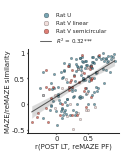

In [41]:
#--------------------------------------------------------------------------------------------------------------------------------------------------
# Scatter plot

unit_subset_index = stable_above_1Hz_PF_unit_index_session_concat


# ---------------------------------------------------------------------------------------------------------------------------------------------------------------
# Define functions

def get_pval_statement(pvalue):
    
    if pvalue <= 0.0001:
        pvalue_statement = '***'
    elif pvalue < 0.001:
        pvalue_statement = '**'
    elif pvalue < 0.01:
        pvalue_statement = '*'
    else:
        pvalue_statement = f'P={pvalue:.2f}'
    
    return pvalue_statement

def format_ticks(x, _):
    if x == int(x):
        return str(int(x))
    else:
        return str(x)

#-----------------------------------------------------------------------------------------------------------------------------------------------------------------
# Set up figure colors and style


sns.set_style('whitegrid') 
sns.set_context('paper')

custom_params = {
    "axes.spines.top": False,
    "axes.spines.right": False
    }

sns.set_theme(style="ticks", rc=custom_params)

plt.rcParams.update({
    'font.size':6,
    'axes.linewidth':0.75,
    'pdf.fonttype':42,
    'ps.fonttype':42,
    'axes.labelsize':6,
    'axes.titlesize':8,
    'xtick.labelsize':5,
    'ytick.labelsize':5,
    'legend.fontsize':6,
    'legend.title_fontsize':6,
    'legend.frameon': False,
    'legend.markerscale':2,
    'xtick.major.size':2,
    'ytick.major.size':2
})

cmap = sns.diverging_palette(220, 15)
session_specific_colors = [cmap[i] for i in [0, 3, 5]]


#-------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Generate the figure

plotheight = 120
plotwidth = 90
font_size = 5

fig = plt.figure()
fig.set_size_inches([plotwidth/72, plotheight/72])
gs = GridSpec(nrows=1, ncols=1, figure=fig, hspace=0.3, wspace=0.5)

ax = fig.add_subplot(gs[0])

xvar = learned_tunings_remaze_place_field_corr_sessions_concat['post']
yvar = place_field_similarity_maze_remaze_sessions_concat

# Scatterplot
for session_idx, session_number in enumerate(current_sessions):
    session_name = rr[session_number]
    unit_subset_current_session = np.where(unit_subset_index & np.isin(each_unit_session_number_session_concat, session_number))[0] # & (place_field_stability_maze_concat < 50)
    sns.scatterplot(
        x=xvar[unit_subset_current_session],
        y=yvar[unit_subset_current_session],
        color = session_specific_colors[session_idx],
        marker='o',
        edgecolor = 'black',
        linewidth=0.2, 
        s=3, 
        alpha=0.7, 
        ax=ax, 
        label = session_name_mapping[session_name]
        )


# Add the regression line
reg_valid_idx = ~np.isnan(xvar) & ~np.isnan(yvar)

slope, intercept, r_value, p_value, std_err = stats.linregress(
    xvar[unit_subset_index & reg_valid_idx],
    yvar[unit_subset_index & reg_valid_idx]
    )
sns.regplot(x=xvar[unit_subset_index], y=yvar[unit_subset_index], ci=95, color='black', scatter=False,
            label=f'$R^{2}$ = {r_value**2:.2f}{get_pval_statement(p_value)}',
            line_kws={"linewidth":0.75, "alpha":0.6},
            ax=ax)

# ax.set_xlim([0, 0.45])
# ax.set_ylim([-0.6, 1.02])

ax.set_xlabel("r(POST LT, reMAZE PF)", fontsize=font_size, labelpad=1)
ax.set_ylabel("MAZE/reMAZE similarity", fontsize=font_size, labelpad=0)

ax.tick_params(axis='both', which='major', length=1, pad=1, width=1)

ax.legend(fontsize=4, loc="upper center", bbox_to_anchor=(0.5, 1.5))

# Format the tick labels using the custom formatter
ax.xaxis.set_major_formatter(FuncFormatter(format_ticks))
ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))

# Adjust the plot layout
plt.subplots_adjust(left=0.22, right= 0.95, bottom=0.2, top=0.70)


filename = 'scatter_plot_maze_reMAZE_place_field_similarity_vs_POST_reMAZE similarity.pdf'
file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, dpi=300)

plt.show()


### POST/MAZE correlation vs POST/reMAZE correlation

In [ ]:
#--------------------------------------------------------------------------------------------------------------------------------------------------
# Scatter plot

unit_subset_index = stable_above_1Hz_PF_unit_index_session_concat


# ---------------------------------------------------------------------------------------------------------------------------------------------------------------
# Define functions

def get_pval_statement(pvalue):
    
    if pvalue <= 0.0001:
        pvalue_statement = '***'
    elif pvalue < 0.001:
        pvalue_statement = '**'
    elif pvalue < 0.01:
        pvalue_statement = '*'
    else:
        pvalue_statement = f'P={pvalue:.2f}'
    
    return pvalue_statement

def format_ticks(x, _):
    if x == int(x):
        return str(int(x))
    else:
        return str(x)

#-----------------------------------------------------------------------------------------------------------------------------------------------------------------
# Set up figure colors and style


sns.set_style('whitegrid') 
sns.set_context('paper')

custom_params = {
    "axes.spines.top": False,
    "axes.spines.right": False
    }

sns.set_theme(style="ticks", rc=custom_params)

plt.rcParams.update({
    'font.size':6,
    'axes.linewidth':0.75,
    'pdf.fonttype':42,
    'ps.fonttype':42,
    'axes.labelsize':6,
    'axes.titlesize':8,
    'xtick.labelsize':5,
    'ytick.labelsize':5,
    'legend.fontsize':6,
    'legend.title_fontsize':6,
    'legend.frameon': False,
    'legend.markerscale':2,
    'xtick.major.size':2,
    'ytick.major.size':2
})

cmap = sns.diverging_palette(220, 15)
session_specific_colors = [cmap[i] for i in [0, 3, 5]]


#-------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Generate the figure

plotheight = 120
plotwidth = 90
font_size = 5

fig = plt.figure()
fig.set_size_inches([plotwidth/72, plotheight/72])
gs = GridSpec(nrows=1, ncols=1, figure=fig, hspace=0.3, wspace=0.5)

ax = fig.add_subplot(gs[0])

xvar = learned_tunings_place_field_corr_sessions_concat['post']
yvar = learned_tunings_remaze_place_field_corr_sessions_concat['post']

# Scatterplot
for session_idx, session_number in enumerate(current_sessions):
    session_name = rr[session_number]
    unit_subset_current_session = np.where(unit_subset_index & np.isin(each_unit_session_number_session_concat, session_number))[0] # & (place_field_stability_maze_concat < 50)
    sns.scatterplot(
        x=xvar[unit_subset_current_session],
        y=yvar[unit_subset_current_session],
        color = session_specific_colors[session_idx],
        marker='o',
        edgecolor = 'black',
        linewidth=0.2, 
        s=3, 
        alpha=0.7, 
        ax=ax, 
        label = session_name_mapping[session_name]
        )


# Add the regression line
reg_valid_idx = ~np.isnan(xvar) & ~np.isnan(yvar)

slope, intercept, r_value, p_value, std_err = stats.linregress(
    xvar[unit_subset_index & reg_valid_idx],
    yvar[unit_subset_index & reg_valid_idx]
    )
sns.regplot(x=xvar[unit_subset_index], y=yvar[unit_subset_index], ci=95, color='black', scatter=False,
            label=f'$R^{2}$ = {r_value**2:.2f}{get_pval_statement(p_value)}',
            line_kws={"linewidth":0.75, "alpha":0.6},
            ax=ax)

# ax.set_xlim([0, 0.45])
# ax.set_ylim([-0.6, 1.02])

ax.set_xlabel("POST fidelity", fontsize=font_size, labelpad=1)
ax.set_ylabel("POST LT/reMAZE similarity", fontsize=font_size, labelpad=0)

ax.tick_params(axis='both', which='major', length=1, pad=1, width=1)

ax.legend(fontsize=4, loc="upper center", bbox_to_anchor=(0.5, 1.5))

# Format the tick labels using the custom formatter
ax.xaxis.set_major_formatter(FuncFormatter(format_ticks))
ax.yaxis.set_major_formatter(FuncFormatter(format_ticks))

# Adjust the plot layout
plt.subplots_adjust(left=0.22, right= 0.95, bottom=0.2, top=0.70)


filename = 'scatter_plot_POST_LT_reMAZE_similarity_vs_POST_fidelity.pdf'
file_path = os.path.join(main_dir, filename)
plt.savefig(file_path, dpi=300)

plt.show()
